# Data preparation



In [97]:
# to view longer dfs I set print option
options(dplyr.print_max = 1e9)
library(microbiome)
library(tidyverse)
library(here)
# load HITChip data using Leo's script
source(here("R/read.R"))
theme_set(theme_bw())

In [98]:
# load sample_data. disregard duplicate samples: %>% distinct(My.SQL.ID, .keep_all = TRUE)
# seems like this metadata is not complete. Therefore I use the excel from Gerben metadata <- sample_data(genus)
# colnames(metadata)
metadata <- readxl::read_excel(here("data/meta_data/my.metadata.xlsx"))
# to select the correct infants I use the resulting dataframe that arised from Gerbens selection process
select_samples <- read_csv(here("data/csv_gerben/complete.csv"))
# to confirm we have 49 pre/post for both groups
select_samples %>% group_by(childcarecenter, groupcode) %>% summarise(n = n())
# rename and disregard samples unrelated to the cc project
metadata <- metadata %>%
    rename(subject_id = subject, sample = "Var.2") %>%
    filter(sample %in% select_samples$sample)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  sample = col_character(),
  Group = col_character(),
  groupcode = col_character(),
  subject = col_integer(),
  childcarecenter = col_integer(),
  breastfeeding = col_integer(),
  Tot_weeks_CC = col_integer(),
  ExactageCCmin2d = col_integer()
)
See spec(...) for full column specifications.


childcarecenter groupcode n 
1 1               KDV1      49
2 1               KDV5      49
3 2               KDV1      49
4 2               KDV5      49

In [99]:
# we have additional information stored in another excel sheet:
# I need to control for the age at CC entrace and the total length of CC (unless CC will extend)
# beyond post, which is just the indicator of the stool sample closest to post
# same for breastfeeding: I need the number or %BF until entrance and then during entrance,
# where % means breasfeedings/(breasfeedings + formula feedings), because those two variables will
# be highly correlated I assume, but I can check that...
# so the questions I need to aks are: have their been children who remained in CC after they gave their second sample?
# I assume that age at sample is in fact not the same among infants? (then 75, 105 etc. should be renamed really)
metadata2 <- readxl::read_excel(here("data/meta_data/my.metadata2.xlsx"), sheet = "Data")
metadata2 <-
    metadata2 %>%
            filter(ID %in% metadata$subject_id) %>%
            rename(
                subject_id = ID,
                cc = Childcare_yesno,
                per_bf_during_cc = `%BEFbetweenKDV1andKDV2`,
                bf_until_end_cc = WeeksBEF,
                age_startcc_w = Begin_age_weeks, 
                age_pre_d = ExactageCCmin2d, 
                age_post_d = ExactageCCplus28) %>%
            mutate(
                age_pre_d = ifelse(is.na(age_pre_d), age_startcc_w * 7 -2, age_pre_d),
                age_post_d = ifelse(is.na(age_post_d), Age_plus4weeks * 7, age_post_d), 
                age_pre_w = age_pre_d/7, 
                age_post_w = age_post_d/7, 
                weeks_cc = (age_post_d - age_pre_d +2)/7)

In [100]:
# how much variation is there in the # of week subjects were in CC between pre and post?
metadata2 %>% summarise(mean_weeks_cc = mean(weeks_cc), sd_weeks_cc = sd(weeks_cc))

mean_weeks_cc sd_weeks_cc
1 4.599155      0.229898

In [101]:
# merge metadata, rename time (because it does not correspond to real age)
meta <- metadata %>%
    left_join(metadata2, by = "subject_id") %>%
    mutate(time = ifelse(time == "75", "pre", "post")) %>%
    select(subject_id, time, cc, age_pre_d, age_post_d, age_startcc_w, weeks_cc, bf_until_end_cc, per_bf_during_cc, sample)

In [102]:
meta %>% head()

subject_id time cc age_pre_d age_post_d age_startcc_w weeks_cc
1 202        pre  1  75        105        11.00         4.571429
2 202        post 1  75        105        11.00         4.571429
3 204        pre  0  72         99        10.57         4.142857
4 204        post 0  72         99        10.57         4.142857
5 207        pre  0  68         98        10.00         4.571429
6 207        post 0  68         98        10.00         4.571429
  bf_until_end_cc per_bf_during_cc sample  
1 15              100              sa_11183
2 15              100              sa_5986 
3  3                0              sa_11180
4  3                0              sa_7451 
5 14              100              sa_832  
6 14              100              sa_10000

In [103]:
# Next we need to load additional metadata about the number of week breastfeeding and formula feeding
# as can be looked up in R/read_metadata_long.R, we get a df called meta_long
# ok I see a problem: above we have bf_before_cc, which is just +1 for each week an infant had bf, thereby
# disregarding the amount of bf. See example for changing average feedings in printed df
source(here("R/read_metadata_long.R"))

In [104]:
# After I had a look at the data above, I now try to replicate the bf_weeks and then change it to a count bf_before_cc
# and a count bf_weeks_cc
meta_long <-
    meta_long %>%
        rename(subject_id = subject) %>%
        filter(subject_id %in% meta$subject_id) %>%
        left_join(meta, by = "subject_id")

In [105]:
# intialize columns
meta$bf_count_pre <- NA
meta$bf_count_post <- NA
meta$bf_count_cc <- NA
meta$formula_count_pre <- NA
meta$formula_count_post <- NA
meta$formula_count_cc <- NA

# select only variables needed. I checked all the infants with NA for bf, formula and exp.bf
# most of the time there is NA for bf if e.g subject was formula fed with high count or vice versa
# if not then these are only a few rows and given the consistency, most reasonably is to insert the value
# that was given before. The infant cannot starve + it received the same number of feedings before.
# only subjects 252, 448 have critically many NA. We would need to impute or drop those 2. They are both cc

# if there is NA but there is info in the other feedings columns, then NA = 0,
# else most likely NA = mean(averge_before) unless subjects are 252 and 448 (why? because mothers throughout the
# whole data are very consistent in feedings behavior and the did not starve the infant for 1-2 days. So, here 
# I make an assumption for these rows. 
bf_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula, week, age_pre_d, age_post_d, age_startcc_w, weeks_cc) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            bf = ifelse(is.na(bf)&(!is.na(expressed_bf)|!is.na(formula)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(bf, na.rm = T), bf))) %>%
        select(subject_id, week, age_pre_d, age_post_d, age_startcc_w, weeks_cc, bf)
#
expressed_bf_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            expressed_bf = ifelse(is.na(expressed_bf)&(!is.na(bf)|!is.na(formula)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(expressed_bf, na.rm = T), expressed_bf))) %>%
        select(expressed_bf)

#
formula_imputed <-
    meta_long %>%
        select(subject_id, bf, expressed_bf, formula) %>%
        filter(!subject_id %in% c(252, 448)) %>%
        mutate(
            formula = ifelse(is.na(formula)&(!is.na(bf)|!is.na(expressed_bf)), 0,
                ifelse(is.na(bf)&is.na(expressed_bf)&is.na(formula), mean(formula, na.rm = T), formula))) %>%
        select(formula)
feeding_imputed <- bind_cols(bf_imputed, expressed_bf_imputed, formula_imputed)
# add expressed bf and bf together because for our research question it does not matter
feeding_imputed <- feeding_imputed %>% mutate(bf = bf + expressed_bf)

In [106]:
feeding_imputed %>% 
    mutate(
        prea = age_pre_d/7, 
        preb = round(age_pre_d/7), 
        posta = age_post_d/7, 
        postb = round(age_post_d/7), 
        diff = posta - prea, 
        diff_r = round(diff), 
        diff_r2 = round(postb - preb)) %>%
    select(subject_id, prea, preb, posta, postb, diff, diff_r, diff_r2, weeks_cc) %>% 
    distinct(subject_id, .keep_all = T)

subject_id prea      preb posta    postb diff     diff_r diff_r2 weeks_cc
1  202        10.714286 11   15.00000 15    4.285714 4      4       4.571429
2  204        10.285714 10   14.14286 14    3.857143 4      4       4.142857
3  207         9.714286 10   14.00000 14    4.285714 4      4       4.571429
4  210        15.857143 16   20.14286 20    4.285714 4      4       4.571429
5  211        10.142857 10   14.42857 14    4.285714 4      4       4.571429
6  213        12.571429 13   16.85714 17    4.285714 4      4       4.571429
7  216         9.714286 10   14.28571 14    4.571429 5      4       4.857143
8  228        10.714286 11   15.14286 15    4.428571 4      4       4.714286
9  233        10.428571 10   14.57143 15    4.142857 4      5       4.428571
10 234        10.000000 10   14.28571 14    4.285714 4      4       4.571429
11 237         9.714286 10   13.85714 14    4.142857 4      4       4.428571
12 240        11.857143 12   16.42857 16    4.571429 5      4       4.857143
13 241        13.857143 14   18.28571 18    4.428571 4      4       4.714286
14 245         9.714286 10   14.14286 14    4.428571 4      4       4.714286
15 249        13.714286 14   17.86000 18    4.145714 4      4       4.431429
16 253        10.714286 11   15.00000 15    4.285714 4      4       4.571429
17 254        11.857143 12   16.85714 17    5.000000 5      5       5.285714
18 258        11.571429 12   15.57143 16    4.000000 4      4       4.285714
19 259        10.857143 11   15.14286 15    4.285714 4      4       4.571429
20 260         9.714286 10   14.00000 14    4.285714 4      4       4.571429
21 264        13.142857 13   17.57143 18    4.428571 4      5       4.714286
22 269        12.000000 12   16.28571 16    4.285714 4      4       4.571429
23 272        10.714286 11   15.14286 15    4.428571 4      4       4.714286
24 273        14.714286 15   19.00000 19    4.285714 4      4       4.571429
25 274         9.714286 10   14.00000 14    4.285714 4      4       4.571429
26 276         9.142857  9   14.00000 14    4.857143 5      5       5.142857
27 277        11.285714 11   15.57143 16    4.285714 4      5       4.571429
28 283        11.142857 11   15.29000 15    4.147143 4      4       4.432857
29 284        14.428571 14   19.00000 19    4.571429 5      5       4.857143
30 292        17.000000 17   21.85714 22    4.857143 5      5       5.142857
⋮  ⋮          ⋮         ⋮    ⋮        ⋮     ⋮        ⋮      ⋮       ⋮       
64 373        11.857143 12   16.14286 16    4.285714 4      4       4.571429
65 378        14.571429 15   19.00000 19    4.428571 4      4       4.714286
66 381        11.142857 11   15.42857 15    4.285714 4      4       4.571429
67 382        15.428571 15   20.00000 20    4.571429 5      5       4.857143
68 383        12.142857 12   16.28571 16    4.142857 4      4       4.428571
69 384         9.714286 10   14.00000 14    4.285714 4      4       4.571429
70 385        12.142857 12   16.28571 16    4.142857 4      4       4.428571
71 388         9.714286 10   14.00000 14    4.285714 4      4       4.571429
72 391        12.142857 12   15.85714 16    3.714286 4      4       4.000000
73 392        15.000000 15   19.28571 19    4.285714 4      4       4.571429
74 396         9.428571  9   14.00000 14    4.571429 5      5       4.857143
75 397        12.000000 12   16.28571 16    4.285714 4      4       4.571429
76 400        11.424286 11   15.71000 16    4.285714 4      5       4.571429
77 403        11.714286 12   16.00000 16    4.285714 4      4       4.571429
78 408        11.714286 12   16.14286 16    4.428571 4      4       4.714286
79 409        11.714286 12   15.85714 16    4.142857 4      4       4.428571
80 413         9.714286 10   14.00000 14    4.285714 4      4       4.571429
81 417        12.000000 12   16.57143 17    4.571429 5      5       4.857143
82 420        10.142857 10   14.42857 14    4.285714 4      4       4.571429
83 421        10.714286 11   15.28571 15    4.571429 5      4       4.857143

In [107]:
# now for each subject and feedintype I need to aggregate the feedings
# I divide the sum by two because each week is in the two times 
for (id in unique(feeding_imputed$subject_id)) {
    # pre CC bf
    bf_count_pre <-
        feeding_imputed %>% filter(subject_id == id, week < round(age_pre_d/7)) %>%
        select(bf) %>%
            sum()/2
    meta[meta$subject_id == id, "bf_count_pre"] = bf_count_pre
    # post CC bf
    bf_count_post <-
        feeding_imputed %>% filter(subject_id == id, week < round(age_post_d/7)) %>%
        select(bf) %>%
            sum()/2
    meta[meta$subject_id == id, "bf_count_post"] = bf_count_post
    # during CC bf
    meta[meta$subject_id == id, "bf_count_cc"] = bf_count_post - bf_count_pre

    # pre CC formula
    formula_count_pre <-
        feeding_imputed %>% filter(subject_id == id, week <= round(age_pre_d/7)) %>%
        select(formula) %>%
            sum()/2
    meta[meta$subject_id == id, "formula_count_pre"] = formula_count_pre
    # post CC formula
    formula_count_post <-
        feeding_imputed %>% filter(subject_id == id, week <= round(age_post_d/7)) %>%
        select(formula) %>%
            sum()/2
    meta[meta$subject_id == id, "formula_count_post"] = formula_count_post
    # during CC formula
    meta[meta$subject_id == id, "formula_count_cc"] = formula_count_post - formula_count_pre
}

In [108]:
meta %>% head()

subject_id time cc age_pre_d age_post_d age_startcc_w weeks_cc
1 202        pre  1  75        105        11.00         4.571429
2 202        post 1  75        105        11.00         4.571429
3 204        pre  0  72         99        10.57         4.142857
4 204        post 0  72         99        10.57         4.142857
5 207        pre  0  68         98        10.00         4.571429
6 207        post 0  68         98        10.00         4.571429
  bf_until_end_cc per_bf_during_cc sample   bf_count_pre bf_count_post
1 15              100              sa_11183 74.5         105.5        
2 15              100              sa_5986  74.5         105.5        
3  3                0              sa_11180 22.5          22.5        
4  3                0              sa_7451  22.5          22.5        
5 14              100              sa_832   78.0         102.0        
6 14              100              sa_10000 78.0         102.0        
  bf_count_cc formula_count_pre formula_count_post formula_count_cc
1 31           0                 1                  1              
2 31           0                 1                  1              
3  0          44                64                 20              
4  0          44                64                 20              
5 24           0                 0                  0              
6 24           0                 0                  0

In [109]:
# those remaining NA are as mentioned completely NA for feedings variables OR there was not even
# an excel sheet for feeding.
meta %>% filter(is.na(bf_count_pre)|is.na(bf_count_post)) %>% distinct(subject_id)

subject_id
1 252       
2 275       
3 443       
4 448       
5 453

In [110]:
test <- meta %>% mutate(check_post = bf_count_post/(round(age_post_d/7)-1))
# they cannot correlate perfectly but should correlate very high
cor.test(test$bf_until_end_cc, test$check_post)
# lets see if formula and bf correlate as I suspected
cor.test(test$bf_count_pre, test$formula_count_pre)
cor.test(test$bf_count_post, test$formula_count_post)
cor.test(test$bf_count_cc, test$formula_count_cc)
# yes...And therefore it might be reasonable to create a ratio out of them or to include only one predictor. 
# one I loose the count, for the other I loose the small variance left unexplained between those predictors
meta <- meta %>%
    mutate(
        bf_ratio_pre = bf_count_pre/(bf_count_pre + formula_count_pre),
        bf_ratio_cc = bf_count_cc/(bf_count_cc + formula_count_cc),
        bf_ratio = ifelse(time == "pre", bf_ratio_pre, bf_ratio_cc),
        bf_count = ifelse(time == "pre", bf_count_pre/(round(age_pre_d/7)-1), bf_count_cc/(round(age_post_d/7) - round(age_pre_d/7))),
        formula_count = ifelse(time == "pre", formula_count_pre/(round(age_pre_d/7) -1), formula_count_cc/(round(age_post_d/7) - round(age_pre_d/7))),
        age_d = ifelse(time == "pre", age_pre_d, age_post_d)
    )

cor.test(meta$formula_count, meta$bf_count)


	Pearson's product-moment correlation

data:  test$bf_until_end_cc and test$check_post
t = 22.879, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8174765 0.8934826
sample estimates:
      cor 
0.8601829 



	Pearson's product-moment correlation

data:  test$bf_count_pre and test$formula_count_pre
t = -25.172, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9090570 -0.8432441
sample estimates:
       cor 
-0.8803185 



	Pearson's product-moment correlation

data:  test$bf_count_post and test$formula_count_post
t = -33.137, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9436870 -0.9016437
sample estimates:
       cor 
-0.9254645 



	Pearson's product-moment correlation

data:  test$bf_count_cc and test$formula_count_cc
t = -36.464, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9526631 -0.9170354
sample estimates:
       cor 
-0.9372515 



	Pearson's product-moment correlation

data:  meta$formula_count and meta$bf_count
t = -30.878, df = 184, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9361156 -0.8887431
sample estimates:
       cor 
-0.9155495 


In [111]:
# I will now merge the data. I later will only need to slect genus for which abundance was not high enough in any sample
# But I don't know how to do this myself yet. Then the data is ready for model fitting.
# Another question is to impute or to use lw deletion.
# I first use lw deletion to see if everything works as expected but if possible I want to impute
# because the information about cc/nocc and time is complete and that is most important!
data <-
    otu_table(genus) %>%
        as.data.frame() %>%
        rownames_to_column("genus") %>%
        mutate_if(is.numeric, log10) %>%
        gather(sample, value, -genus) %>%
        spread(genus, value) %>%
        filter(sample %in% meta$sample) %>%
        left_join(meta, by = "sample") %>%
        select(colnames(meta), everything()) %>%
        select(- bf_until_end_cc, -per_bf_during_cc) # deselecting the old vars

data <- data %>% mutate(cc = ifelse(cc == 0, "no", "yes")) %>%
                  mutate(
                      cc = factor(cc, levels = c("no", "yes")),
                      time = factor(time, levels = c("pre", "post")),
                      bf_count_s = scale(bf_count)[, 1],
                      formula_count_s = scale(formula_count)[, 1],
                      age_d_s = scale(age_d)[, 1],
)


Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  X1_1 = col_character(),
  subject = col_integer(),
  age_weeks = col_integer(),
  feeding_type = col_character(),
  time = col_integer(),
  childcarecenter = col_character()
)
See spec(...) for full column specifications.


Saving 7 x 7 in image


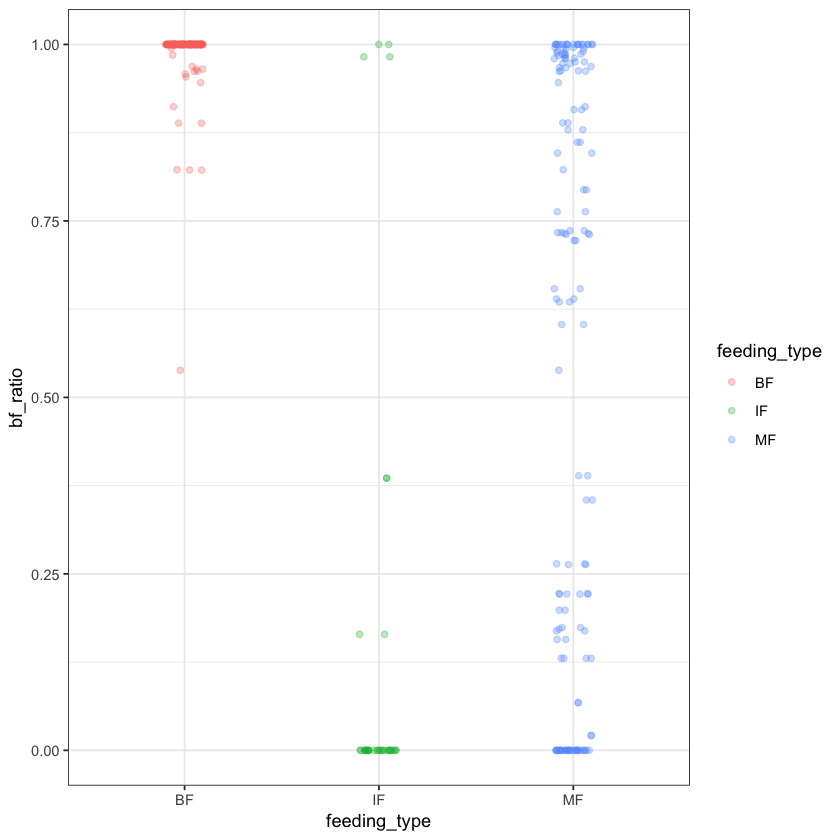

In [112]:
# finally I want to check how the bfratio is reflected in the
# food categories Gerben created. They should be similar despite
# some bf ratios that are not 1 or 0. But we see that some subjects should
# be in bf category but they ended in IF. Some of mixed
# should be either bf of if...
test <- read_csv(here("data/csv_gerben/data1.csv"))
test %>% select(subject, feeding_type) %>%
    rename(subject_id = subject) %>%
    left_join(data, by = "subject_id") %>%
    ggplot(aes(feeding_type, bf_ratio, color = feeding_type)) +
    geom_jitter(width = 0.1, alpha = 0.3)
ggsave("feeding_type_vs_bf_ratio.png")


# Model fitting



In [113]:
library(brms)
library(glue)
options(mc.cores = 4)
colnames(data) <- gsub(" ", "_", colnames(data))
colnames(data) <- gsub("\\.", "", colnames(data))
colnames(data)[which(colnames(data) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(data)
# check default contrasts
contrasts(data$time)

[1] "subject_id"                          
  [2] "time"                                
  [3] "cc"                                  
  [4] "age_pre_d"                           
  [5] "age_post_d"                          
  [6] "age_startcc_w"                       
  [7] "weeks_cc"                            
  [8] "sample"                              
  [9] "bf_count_pre"                        
 [10] "bf_count_post"                       
 [11] "bf_count_cc"                         
 [12] "formula_count_pre"                   
 [13] "formula_count_post"                  
 [14] "formula_count_cc"                    
 [15] "bf_ratio_pre"                        
 [16] "bf_ratio_cc"                         
 [17] "bf_ratio"                            
 [18] "bf_count"                            
 [19] "formula_count"                       
 [20] "age_d"                               
 [21] "Actinomycetaceae"                    
 [22] "Aerococcus"                          
 [23] "Aeromonas"                           
 [24] "Akkermansia"                         
 [25] "Alcaligenes_faecalis_et_rel"         
 [26] "Allistipes_et_rel"                   
 [27] "Anaerobiospirillum"                  
 [28] "Anaerofustis"                        
 [29] "Anaerostipes_caccae_et_rel"          
 [30] "Anaerotruncus_colihominis_et_rel"    
 [31] "Anaerovorax_odorimutans_et_rel"      
 [32] "Aneurinibacillus"                    
 [33] "Aquabacterium"                       
 [34] "Asteroleplasma_et_rel"               
 [35] "Atopobium"                           
 [36] "Bacillus"                            
 [37] "Bacteroides_fragilis_et_rel"         
 [38] "Bacteroides_intestinalis_et_rel"     
 [39] "Bacteroides_ovatus_et_rel"           
 [40] "Bacteroides_plebeius_et_rel"         
 [41] "Bacteroides_splachnicus_et_rel"      
 [42] "Bacteroides_stercoris_et_rel"        
 [43] "Bacteroides_uniformis_et_rel"        
 [44] "Bacteroides_vulgatus_et_rel"         
 [45] "Bifidobacterium"                     
 [46] "Bilophila_et_rel"                    
 [47] "Brachyspira"                         
 [48] "Bryantella_formatexigens_et_rel"     
 [49] "Bulleidia_moorei_et_rel"             
 [50] "Burkholderia"                        
 [51] "Butyrivibrio_crossotus_et_rel"       
 [52] "Campylobacter"                       
 [53] "Catenibacterium_mitsuokai_et_rel"    
 [54] "Clostridium_sensu_stricto"           
 [55] "Clostridium_cellulosi_et_rel"        
 [56] "Clostridium_colinum_et_rel"          
 [57] "Clostridium_difficile_et_rel"        
 [58] "Clostridium_felsineum_et_rel"        
 [59] "Clostridium_leptum_et_rel"           
 [60] "Clostridium_nexile_et_rel"           
 [61] "Clostridium_orbiscindens_et_rel"     
 [62] "Clostridium_ramosum_et_rel"          
 [63] "Clostridium_sphenoides_et_rel"       
 [64] "Clostridium_stercorarium_et_rel"     
 [65] "Clostridium_symbiosum_et_rel"        
 [66] "Clostridium_thermocellum_et_rel"     
 [67] "Collinsella"                         
 [68] "Coprobacillus_catenaformis_et_rel"   
 [69] "Coprococcus_eutactus_et_rel"         
 [70] "Corynebacterium"                     
 [71] "Desulfovibrio_et_rel"                
 [72] "Dialister"                           
 [73] "Dorea_formicigenerans_et_rel"        
 [74] "Eggerthella_lenta_et_rel"            
 [75] "Enterobacter_aerogenes_et_rel"       
 [76] "Enterococcus"                        
 [77] "Escherichia_coli_et_rel"             
 [78] "Eubacterium_biforme_et_rel"          
 [79] "Eubacterium_cylindroides_et_rel"     
 [80] "Eubacterium_hallii_et_rel"           
 [81] "Eubacterium_limosum_et_rel"          
 [82] "Eubacterium_rectale_et_rel"          
 [83] "Eubacterium_siraeum_et_rel"          
 [84] "Eubacterium_ventriosum_et_rel"       
 [85] "Faecalibacterium_prausnitzii_et_rel" 
 [86] "Fusobacteria"                        
 [87] "Gemella"                             
 [88] "Granulicatella"                      
 [89] "Haemophilus"                       

post
pre  0   
post 1

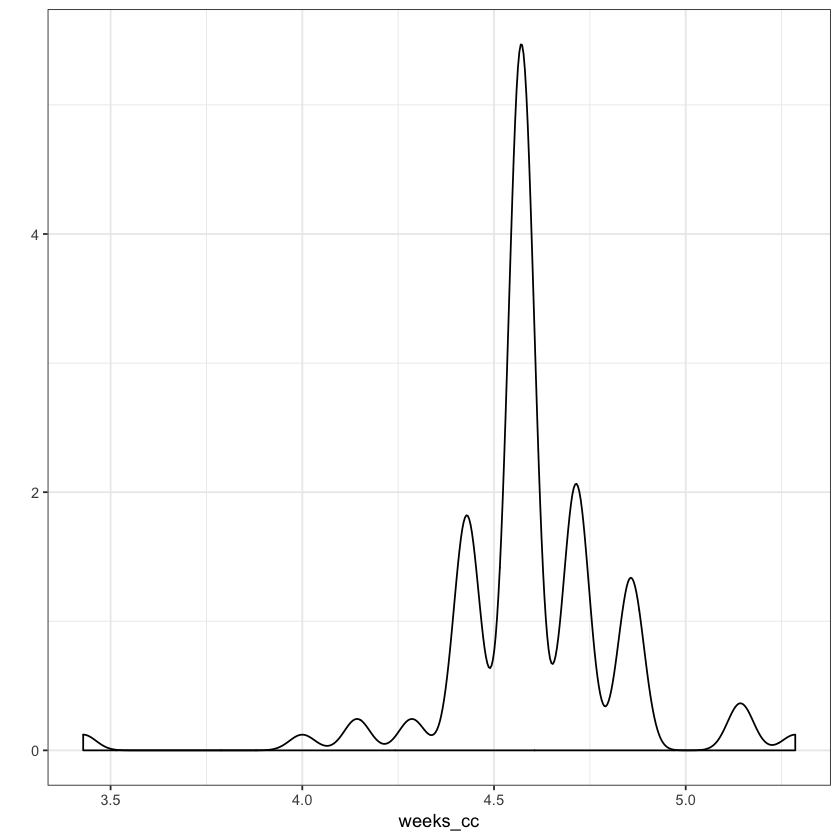

In [21]:
# How much variation in how long they went to cc is there?
qplot(weeks_cc, data = data, geom = "density")


## G vs T vs SN and relax sigma or not?

At first, I want to get some insight in which models are appropriate. Only if I find an appropriate model will I look at the actual coeffients of the models. I want to compare hierarchical generalized linear models of different families but also whether relaxing the assumption of constant variance improves the predictions of the model (I assume that if it does not, then should better stay away until I better understand why not). For the latter type of models, the linear equation predicts both, a location parameter $\mu$ and a scale parameter $\sigma$.

I hope I can later automate more but first I need to get a feeling for how these models behave. So for some genus, I will fit 3 families, and also both distributional ($\sigma$ is not constant) and the "regular" GLMs.

## Bilophila et rel
This genus has a small range in our dataset and is skewed.



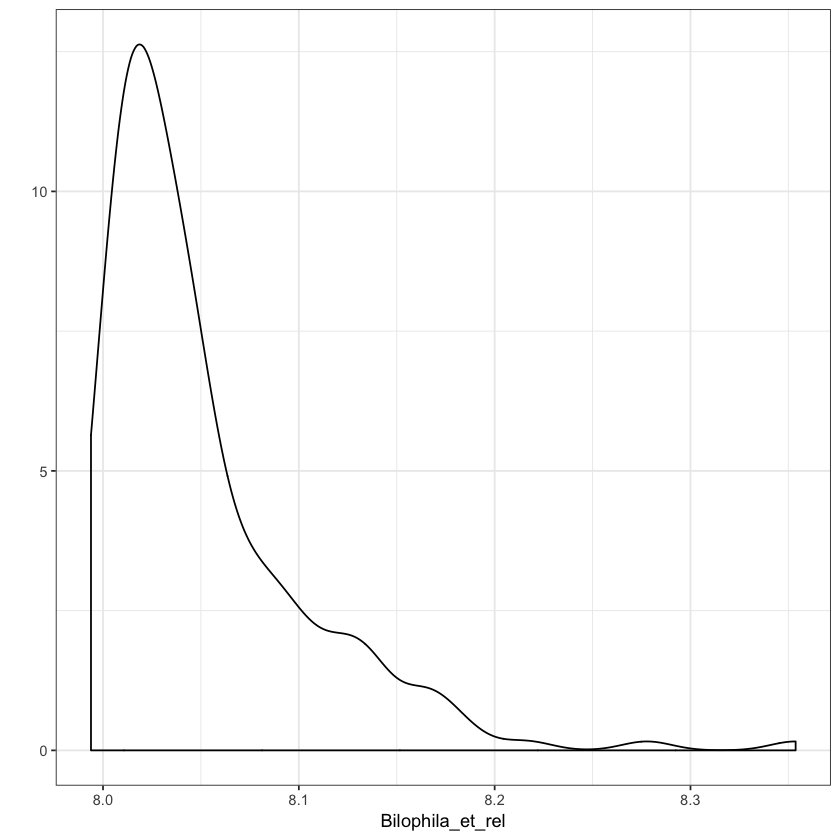

In [22]:
qplot(data = data, Bilophila_et_rel, geom = "density")

In [154]:
# set model options for distributional models
genus <-"Bilophila_et_rel"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))

folder_d <- here("models/cc_and_feeding/distributional/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
chains <- 4
iter <- 3000
warmup <- 1000
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# define fitting functions for distributional models
brmd_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

# set model options for constant sigma models
genus <-"Bilophila_et_rel"
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)

folder <- here("models/cc_and_feeding/constant/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(10)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)



# define fitting functions for constant models
brm_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

In [155]:
cc_time_dg <- brmd_g()

In [156]:
cc_time_dt <- brmd_t()

In [157]:
cc_time_dsn <- brmd_sn()


**Thoughts:**
- I need to put a quite strong prior on the sd parameter, especially for the  t an gaussian models. Thus, the model is very sceptical of high variation there.
- I would only know how to automate if I put strong priors also on the others models that would also fit without warning with less regularizing priors. I could try to see if the estimates differ for skew normal if I put stronger priors there as well (edit: the estimates were not impacted)



In [158]:
source(here("R/bayesian_helper.R"))
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

This is loo version 2.0.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.



According to the pp_checks, the skew_normal family can reproduce the data very nicely. I understand it like this: All models have to increase sigma to capture the outliers to the right compared to outcome distribution that was closer to a gaussian distribution. But for the symmetric models, this leads to outliers to the left as well, which we do not see in our real data. If there was a linear combitation of predictors that could be able to explain mean and variance of those outliers that problem would disappear. The student t model did not converge without a warning with the prior I tested. Therefore; I will ignore the coefficients for that model. Before I will interpret this model, I want model another genus that has a higher range in the distribution.



In [159]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                             term     estimate   std.error        lower
1                     b_Intercept  8.046292227 0.007781741  8.034626448
2               b_sigma_Intercept -3.264899190 0.181449631 -3.569838478
3                      b_timepost -0.017587515 0.006273280 -0.028637024
4                         b_ccyes -0.003421788 0.008282538 -0.017366222
5                b_timepost:ccyes  0.007740884 0.008592438 -0.005292335
6                b_sigma_timepost -0.544238210 0.249141545 -0.963865573
7                   b_sigma_ccyes -0.335834941 0.246830085 -0.747621956
8          b_sigma_timepost:ccyes  0.629681353 0.313426197  0.133716644
9        sd_subject_id__Intercept  0.019674698 0.006851299  0.009161192
10 sd_subject_id__sigma_Intercept  0.615504687 0.134388791  0.421210799
          upper
1   8.059798115
2  -2.972987849
3  -0.008096991
4   0.009838779
5   0.022890521
6  -0.168945069
7   0.063207629
8   1.154560799
9   0.031139926
10  0.814953356

[[2]]
                             term     estimate   std.error        lower
1                     b_Intercept  8.049525559 0.007371507  8.037653091
2               b_sigma_Intercept -3.615707661 0.246587187 -4.037052408
3                      b_timepost -0.019037408 0.006646142 -0.030607791
4                         b_ccyes -0.004912821 0.008989495 -0.019878947
5                b_timepost:ccyes  0.011757612 0.008945060 -0.002235329
6                b_sigma_timepost -0.812554395 0.426246082 -1.571796638
7                   b_sigma_ccyes -0.517794295 0.327170953 -1.082375668
8          b_sigma_timepost:ccyes  1.033732767 0.551260733  0.191460239
9        sd_subject_id__Intercept  0.026601227 0.005517517  0.017009390
10 sd_subject_id__sigma_Intercept  0.048973334 0.060689443  0.002068736
          upper
1   8.062038449
2  -3.233299275
3  -0.008872804
4   0.009655396
5   0.027103965
6  -0.202400768
7  -0.005061873
8   2.012310790
9   0.034692196
10  0.157170730

[[3]]
                             term     estimate   std.error         lower
1                     b_Intercept  8.063817434 0.006975829  8.0530407410
2               b_sigma_Intercept -3.017845968 0.111531888 -3.2010450593
3                      b_timepost -0.026231514 0.008107599 -0.0402941227
4                         b_ccyes -0.002368250 0.009884033 -0.0184729780
5                b_timepost:ccyes  0.016428821 0.011905594 -0.0032235656
6                b_sigma_timepost -0.409617576 0.154366042 -0.6642338777
7                   b_sigma_ccyes -0.040590396 0.165189460 -0.3148774339
8          b_sigma_timepost:ccyes  0.338349631 0.217970479 -0.0222761932
9        sd_subject_id__Intercept  0.003580963 0.002869258  0.0002770399
10 sd_subject_id__sigma_Intercept  0.096361719 0.072062121  0.0057668569
          upper
1   8.075948957
2  -2.828226722
3  -0.013334412
4   0.014030771
5   0.035837617
6  -0.156545396
7   0.226770072
8   0.691123259
9   0.009030568
10  0.228070626

In [157]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [160]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

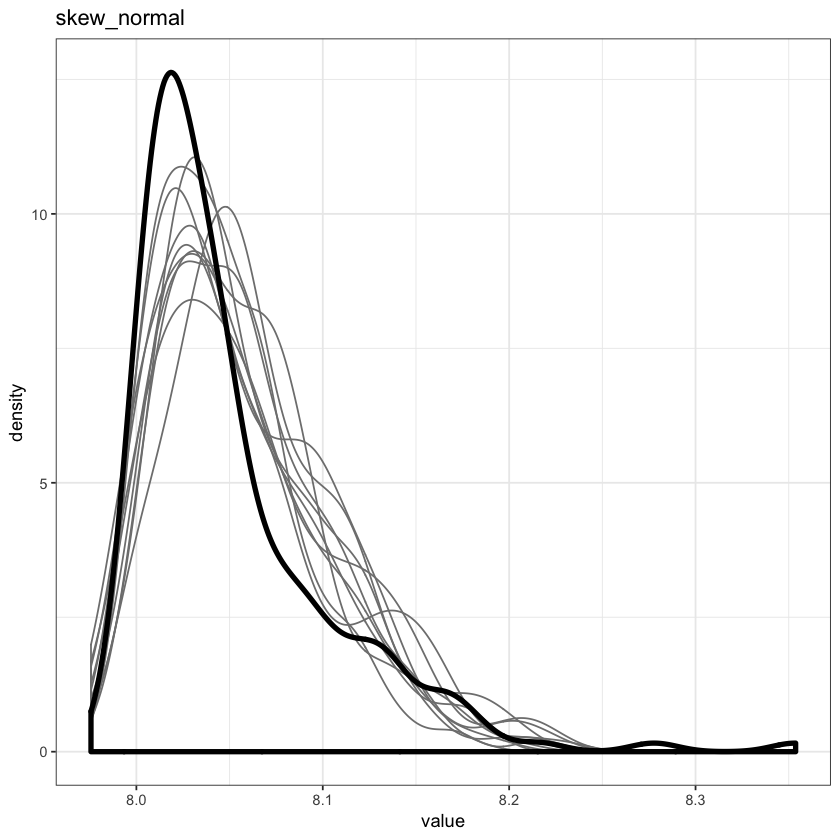

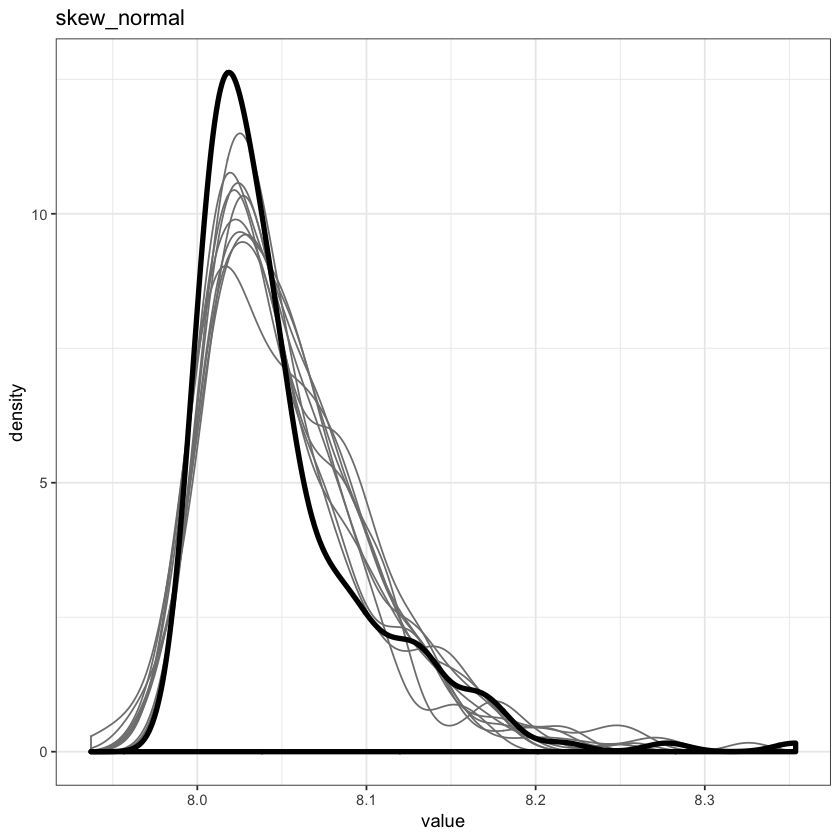

In [161]:
# take a closer look at the ppchecks of the best models constant sigma
# vs modelled sigma. I found that it can be helpful to inspect both violin
# and the density plots...
inspect_c2[[3]]
inspect_d2[[3]]

In [118]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                          term     estimate   std.error        lower
1                  b_Intercept  8.062396870 0.007627141  8.049836777
2                   b_timepost -0.027449870 0.007013230 -0.039047206
3                      b_ccyes -0.006172680 0.010777259 -0.024040691
4             b_timepost:ccyes  0.020213315 0.009889128  0.004234247
5     sd_subject_id__Intercept  0.040447395 0.004236618  0.033636717
6                        sigma  0.034329727 0.002521310  0.030498322
7  r_subject_id[202,Intercept]  0.063832070 0.021897955  0.027410009
8  r_subject_id[204,Intercept]  0.041062878 0.021627298  0.005349420
9  r_subject_id[207,Intercept] -0.005110677 0.020930731 -0.039809968
10 r_subject_id[210,Intercept] -0.002254076 0.021220877 -0.036855592
         upper
1   8.07491282
2  -0.01611016
3   0.01116131
4   0.03650368
5   0.04762536
6   0.03876219
7   0.09982179
8   0.07647131
9   0.02993724
10  0.03253153

[[2]]
                          term      estimate   std.error         lower
1                  b_Intercept  8.0494973869 0.006884267  8.0383816495
2                   b_timepost -0.0182286020 0.006371886 -0.0290837187
3                      b_ccyes -0.0048321586 0.008427575 -0.0187124914
4             b_timepost:ccyes  0.0111516808 0.008858624 -0.0029562631
5     sd_subject_id__Intercept  0.0262101629 0.005466006  0.0169244436
6                        sigma  0.0208651647 0.004122106  0.0144019514
7                           nu  2.2912344900 0.908065090  1.3469904972
8  r_subject_id[202,Intercept]  0.0532869480 0.030343935 -0.0009405421
9  r_subject_id[204,Intercept]  0.0038332419 0.019289722 -0.0253221848
10 r_subject_id[207,Intercept]  0.0002415069 0.017046068 -0.0272917900
          upper
1   8.061015104
2  -0.008302098
3   0.008843019
4   0.026124398
5   0.034436089
6   0.028022725
7   3.778032706
8   0.096170261
9   0.037614332
10  0.028239836

[[3]]
                          term      estimate   std.error         lower
1                  b_Intercept  8.0601422635 0.004637434  8.0524909884
2                   b_timepost -0.0101219255 0.005850230 -0.0199985467
3                      b_ccyes -0.0006799069 0.005822098 -0.0104676340
4             b_timepost:ccyes  0.0044330711 0.007962932 -0.0085969295
5     sd_subject_id__Intercept  0.0042616204 0.003077557  0.0003932392
6                        sigma  0.0451447647 0.002476730  0.0411897088
7                        alpha  9.8131966621 2.030380627  6.7840716908
8  r_subject_id[202,Intercept]  0.0013560519 0.005603616 -0.0059892525
9  r_subject_id[204,Intercept]  0.0010380202 0.005554564 -0.0068357404
10 r_subject_id[207,Intercept]  0.0001249971 0.005032298 -0.0078072486
          upper
1   8.067735812
2  -0.000775188
3   0.008733228
4   0.017637680
5   0.010132363
6   0.049359062
7  13.441168399
8   0.011113296
9   0.010741546
10  0.008503401

The constant sigma model does not appear to be any worse if I only look at the predictive check. I miss other criteria to decide, which one then should be preferred for inference.


## Enterococcus
Again the distribution is skewed. If our predictors do not explain distribution, we get similar issues as with Bilophila.



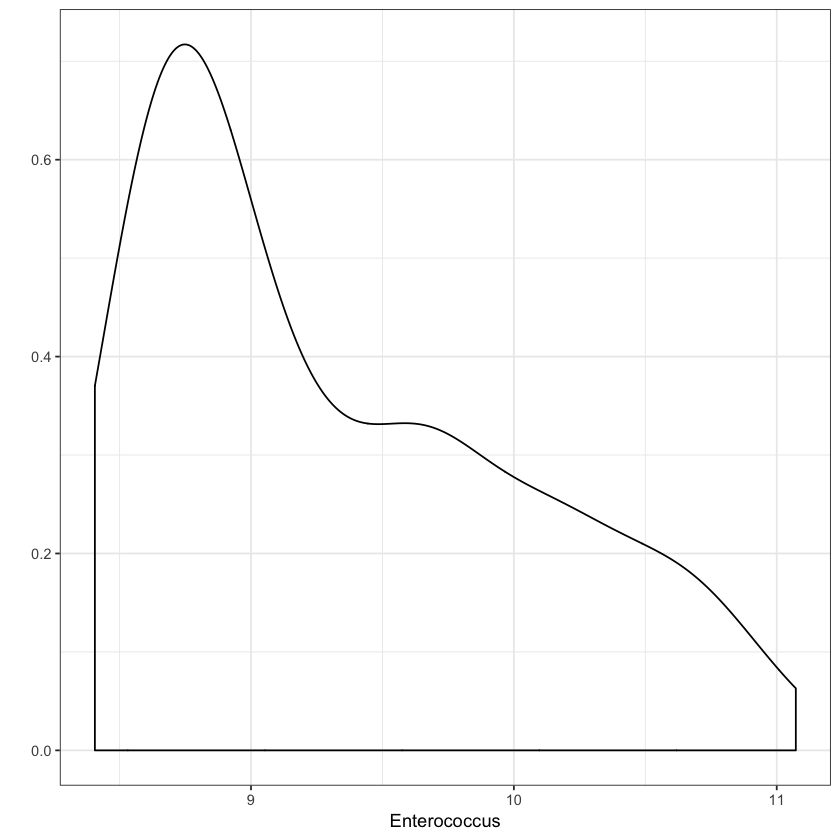

In [247]:
qplot(data = data, Enterococcus, geom = "density")

In [248]:
# set model options distributional
genus <- "Enterococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 1)", class = "b"),
            set_prior("exponential(15)", class = "sd"),
            set_prior("normal(0, 5)", class = "Intercept"),
            set_prior("normal(0, 1)", class = "b", dpar = "sigma"),
            set_prior("exponential(15)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [249]:
cc_time_dg <- brmd_g()

In [250]:
cc_time_dt <- brmd_t()

In [251]:
cc_time_dsn <- brmd_sn()


As wen can see: Even starting with weaker priors, we can fit all models.



In [252]:
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })


Again, the skew normal seems most appropriate because it avoids predicting as many outliers to the left whereas all models predict outliers to the right. The coefficients indicate that the predictors can explain some of the distribution of Enterococcus although the effects appear to be smallest in the model that best could reproduce the data. I am not really happy with any of the models because of the outliers to the right. After showing the coefficients below I will fit one more genus before I start adding bf_ratio as a predictor...



In [253]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                             term    estimate  std.error        lower
1                     b_Intercept  9.12058040 0.08715475  8.978182957
2               b_sigma_Intercept -0.97945149 0.20357021 -1.326073711
3                      b_timepost  0.29228098 0.08728687  0.152423354
4                         b_ccyes  0.31354893 0.14449543  0.072982730
5                b_timepost:ccyes -0.39374742 0.14954298 -0.639062939
6                b_sigma_timepost  0.22237708 0.25789218 -0.182308785
7                   b_sigma_ccyes  0.53831332 0.23149766  0.176401314
8          b_sigma_timepost:ccyes -0.35588710 0.32969547 -0.905061554
9        sd_subject_id__Intercept  0.45405311 0.05738406  0.359310652
10 sd_subject_id__sigma_Intercept  0.08303753 0.07731256  0.004239597
        upper
1   9.2645301
2  -0.6723736
3   0.4343416
4   0.5507362
5  -0.1491745
6   0.6564716
7   0.9298784
8   0.1707925
9   0.5458177
10  0.2412346

[[2]]
                             term    estimate  std.error        lower
1                     b_Intercept  9.11655035 0.08481567  8.980262587
2               b_sigma_Intercept -1.08658677 0.22994318 -1.496419074
3                      b_timepost  0.28727471 0.08550379  0.151049792
4                         b_ccyes  0.30433110 0.14222368  0.071219512
5                b_timepost:ccyes -0.38507223 0.15092336 -0.636417851
6                b_sigma_timepost  0.23403305 0.27852487 -0.197425855
7                   b_sigma_ccyes  0.58150261 0.24893100  0.193272191
8          b_sigma_timepost:ccyes -0.37662600 0.35414312 -0.975141986
9        sd_subject_id__Intercept  0.46721027 0.05696211  0.373936653
10 sd_subject_id__sigma_Intercept  0.07506825 0.07268141  0.003709439
        upper
1   9.2573831
2  -0.7550565
3   0.4287242
4   0.5387613
5  -0.1406241
6   0.7139095
7   1.0062733
8   0.1930994
9   0.5603908
10  0.2257853

[[3]]
                             term    estimate  std.error        lower
1                     b_Intercept  9.16436030 0.07486657  9.051081156
2               b_sigma_Intercept -0.59148482 0.10769663 -0.763053541
3                      b_timepost  0.23511557 0.11968976  0.042463521
4                         b_ccyes  0.27635487 0.12427990  0.075189079
5                b_timepost:ccyes -0.30904673 0.17562749 -0.600999356
6                b_sigma_timepost  0.23911640 0.14654251 -0.004457502
7                   b_sigma_ccyes  0.31613204 0.14645499  0.076376117
8          b_sigma_timepost:ccyes -0.37144309 0.20116608 -0.702056944
9        sd_subject_id__Intercept  0.03934835 0.03741804  0.002602273
10 sd_subject_id__sigma_Intercept  0.03069817 0.02567249  0.002084194
         upper
1   9.29445585
2  -0.41002946
3   0.43120221
4   0.47976119
5  -0.02083455
6   0.47733654
7   0.55643733
8  -0.03786278
9   0.10623524
10  0.08185335

In [254]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [255]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

Warning message:
“Removed 54 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 54 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

Warning message:
“Removed 45 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 45 rows containing missing values (geom_point).”

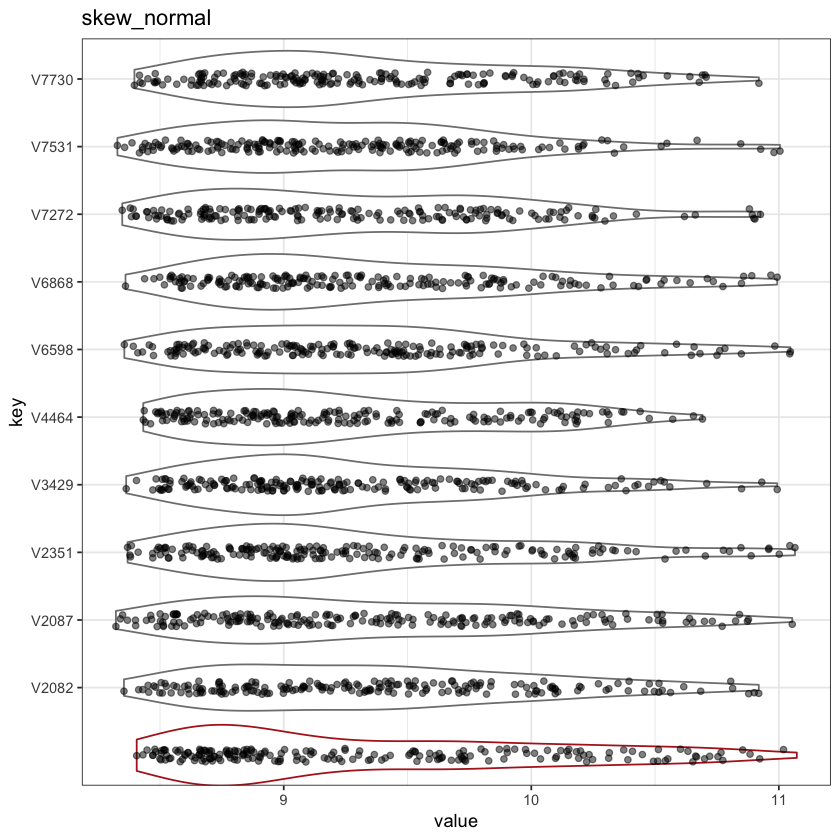

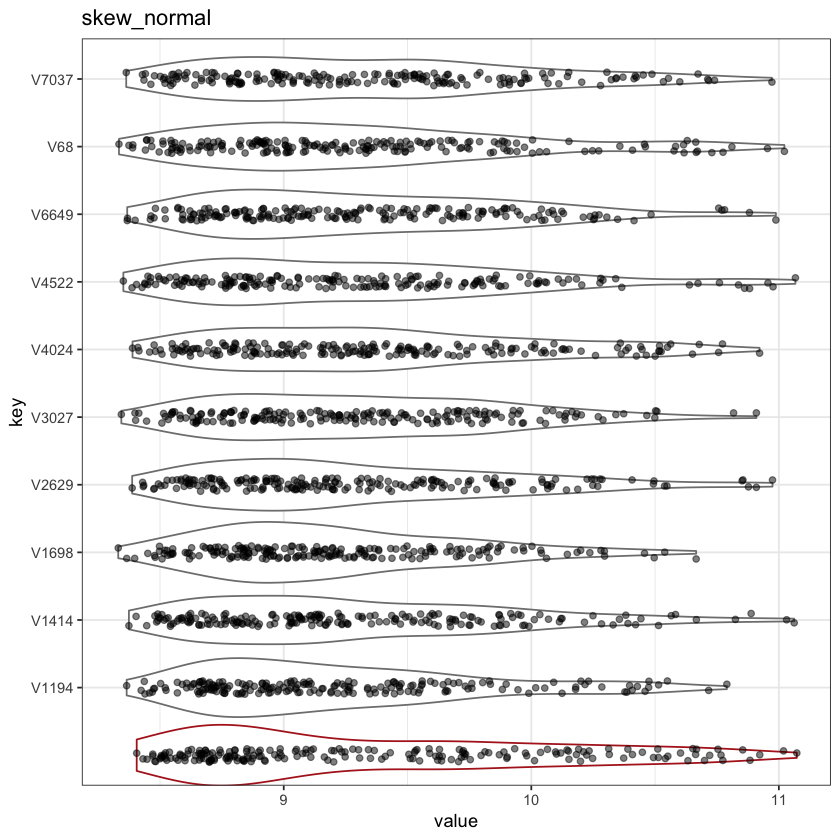

In [258]:
inspect_c[[3]]
inspect_d[[3]] + facet_wrap(~)

In [257]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                          term   estimate  std.error       lower       upper
1                  b_Intercept  9.1234545 0.09817768  8.95991339  9.28580622
2                   b_timepost  0.3009207 0.12083987  0.09880105  0.49193369
3                      b_ccyes  0.3248866 0.13945367  0.09469477  0.55411038
4             b_timepost:ccyes -0.4114967 0.17264453 -0.70093851 -0.13017241
5     sd_subject_id__Intercept  0.3038581 0.14226649  0.01629811  0.47144101
6                        sigma  0.5992799 0.07260007  0.50078195  0.73281821
7  r_subject_id[202,Intercept] -0.2757302 0.28846774 -0.78856865  0.10743714
8  r_subject_id[204,Intercept] -0.2374113 0.27116568 -0.72104848  0.12451363
9  r_subject_id[207,Intercept] -0.2965737 0.30037141 -0.82767074  0.09870586
10 r_subject_id[210,Intercept]  0.3649856 0.31919317 -0.05306231  0.91740164

[[2]]
                          term   estimate   std.error       lower       upper
1                  b_Intercept  9.1133541  0.09785840  8.95348827  9.27366523
2                   b_timepost  0.3022929  0.11428316  0.11290534  0.49246164
3                      b_ccyes  0.3211008  0.13997485  0.09476462  0.55273252
4             b_timepost:ccyes -0.4100373  0.16601778 -0.68362747 -0.13260800
5     sd_subject_id__Intercept  0.3588593  0.11611662  0.05150227  0.49586972
6                        sigma  0.5501779  0.06859504  0.45444641  0.68684041
7                           nu 27.1392730 15.02671547  8.83011482 55.54870216
8  r_subject_id[202,Intercept] -0.3422539  0.29147776 -0.84078044  0.09125569
9  r_subject_id[204,Intercept] -0.2960072  0.28026682 -0.77284695  0.12154906
10 r_subject_id[207,Intercept] -0.3655231  0.29949716 -0.87269914  0.07437784

[[3]]
                          term     estimate  std.error       lower       upper
1                  b_Intercept  9.282240154 0.06796397  9.16858284  9.39036289
2                   b_timepost  0.083908563 0.08024204 -0.04637578  0.21711881
3                      b_ccyes  0.069887262 0.07878811 -0.05622491  0.20260955
4             b_timepost:ccyes -0.061432360 0.11161785 -0.24852663  0.12036036
5     sd_subject_id__Intercept  0.030223806 0.02659212  0.00170010  0.08374374
6                        sigma  0.677299838 0.03652808  0.62051158  0.74069559
7                        alpha 10.244896059 2.16226040  7.05025691 14.13771578
8  r_subject_id[202,Intercept] -0.005685795 0.03831151 -0.07038735  0.04695136
9  r_subject_id[204,Intercept] -0.004286411 0.03835634 -0.07133339  0.04945463
10 r_subject_id[207,Intercept] -0.018010722 0.04314085 -0.10319949  0.02750955

## Example contrasts

Since the contrast setting here is *contr.treatment* and the reference groups are pre (time) and noCC (cc), we can answer the question about whether the groups differ from each other as in the next cell. In the plots I compare the $\mu$ against the mean of *Enterococcus* abundance in all samples. This might be misleading however given the skew of the raw data. However, the differences should be informative instead. There, the dashed line represents 0.

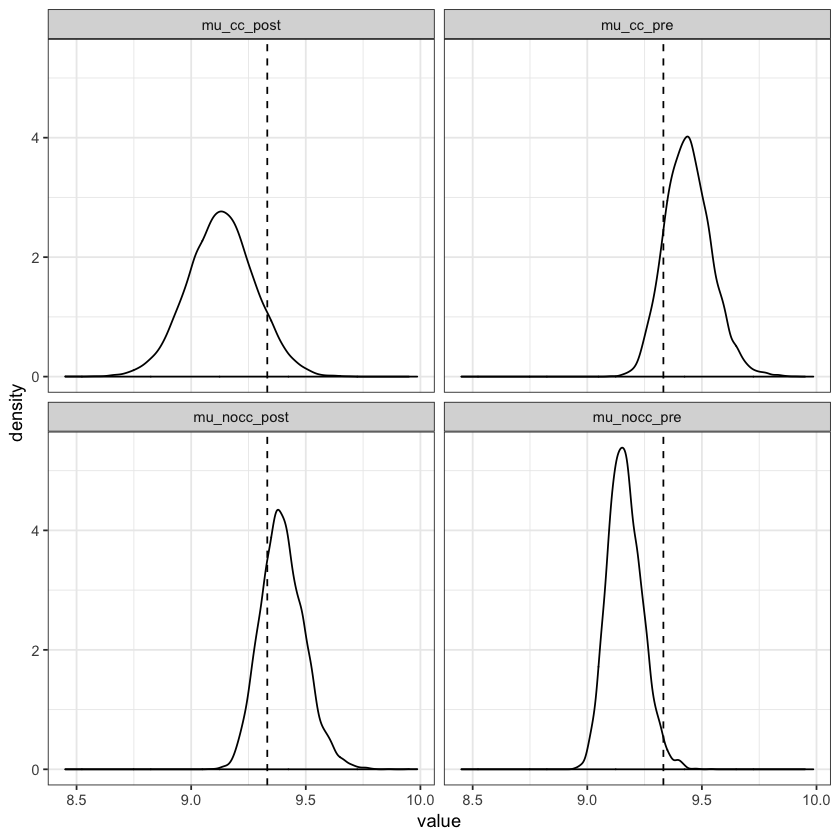

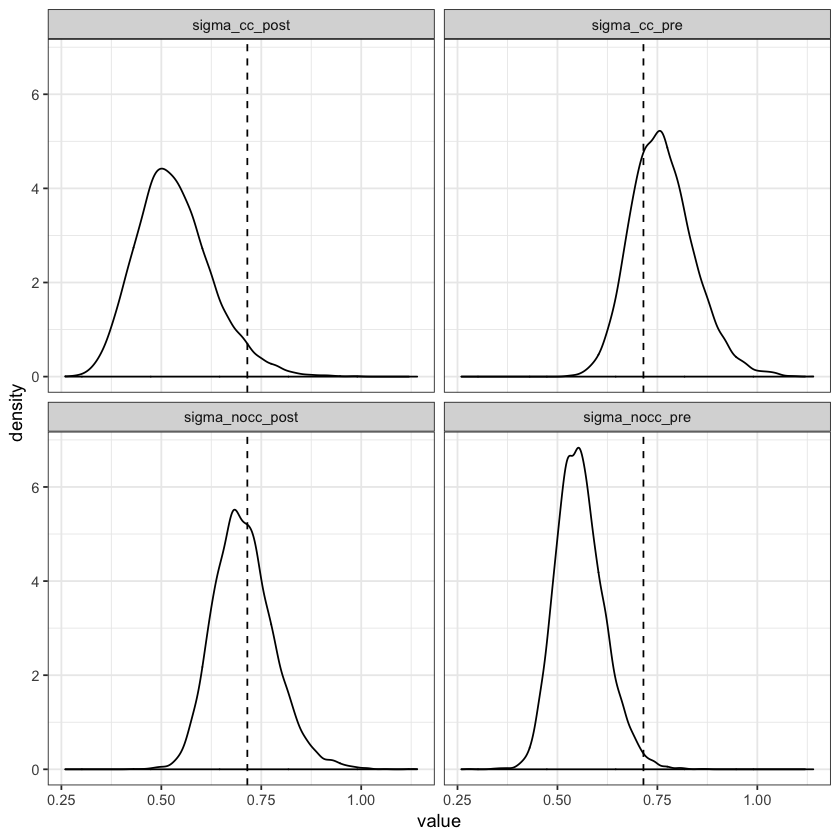

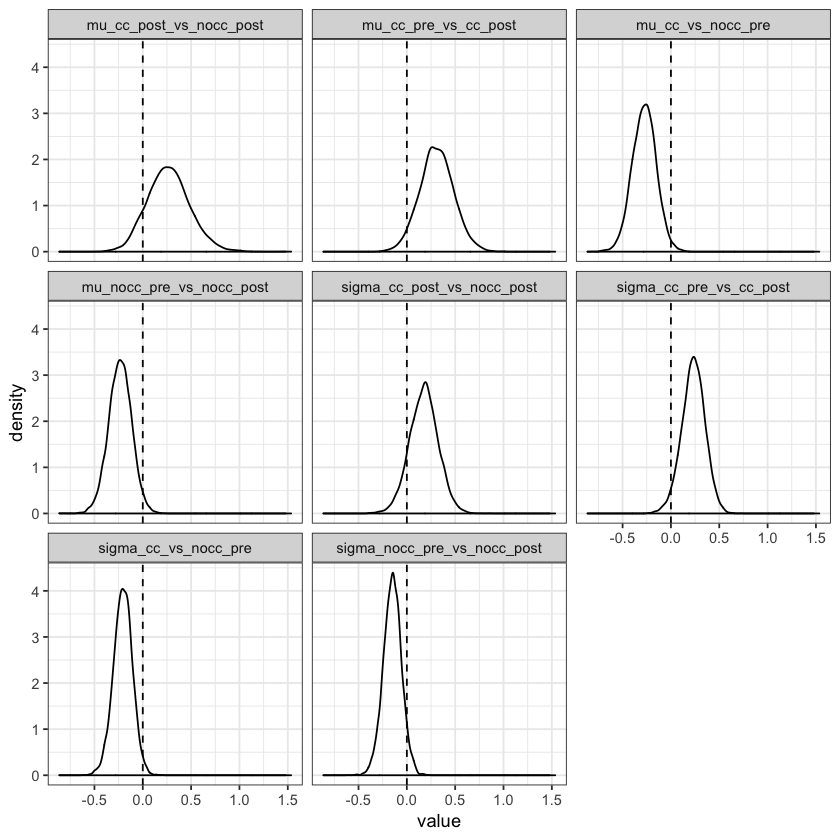

In [311]:
mus_and_sigmas <- 
    cc_time_dsn %>% 
        as.tibble() %>% 
        mutate(
            mu_nocc_pre = b_Intercept,
            mu_nocc_post = b_Intercept + b_timepost,
            mu_cc_pre = b_Intercept + b_ccyes,
            mu_cc_post = b_Intercept + b_ccyes + b_timepost.ccyes,
            sigma_nocc_pre = exp(b_sigma_Intercept),
            sigma_nocc_post = exp(b_sigma_Intercept + b_sigma_timepost),
            sigma_cc_pre = exp(b_sigma_Intercept + b_sigma_ccyes),
            sigma_cc_post = exp(b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost.ccyes),
        ) %>% select(c(209:216))


mus_and_sigmas %>% select(contains("mu")) %>% gather(estimate, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = mean(data$Enterococcus), linetype = "dashed") +
    facet_wrap(~estimate)
                          
mus_and_sigmas %>% select(contains("sigma")) %>% gather(estimate, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = sd(data$Enterococcus), linetype = "dashed") +
    facet_wrap(~estimate)


diffs <- 
    mus_and_sigmas %>% 
        mutate(mu_cc_vs_nocc_pre = mu_nocc_pre - mu_cc_pre,
               mu_cc_post_vs_nocc_post = mu_nocc_post - mu_cc_post,
               mu_cc_pre_vs_cc_post = mu_cc_pre - mu_cc_post,
               mu_nocc_pre_vs_nocc_post = mu_nocc_pre - mu_nocc_post,
               sigma_cc_vs_nocc_pre = (sigma_nocc_pre - sigma_cc_pre),
               sigma_cc_post_vs_nocc_post = (sigma_nocc_post - sigma_cc_post),
               sigma_cc_pre_vs_cc_post = (sigma_cc_pre - sigma_cc_post),
               sigma_nocc_pre_vs_nocc_post = (sigma_nocc_pre - sigma_nocc_post)
              ) %>% select(c(9:16))  

diffs %>%
    gather(comparison, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dashed") +
    facet_wrap(~comparison)

In [312]:
diffs %>% 
    gather(comparison, value) %>%
    group_by(comparison) %>%
    do(data.frame(
        mean = mean(.$value),
        lower = hpdi(.$value, prob = 0.95)[1],
        upper = hpdi(.$value, prob = 0.95)[2]
    ))
    

comparison                  mean       lower       upper      
1 mu_cc_post_vs_nocc_post      0.2678074 -0.14894732  0.70446837
2 mu_cc_pre_vs_cc_post         0.3090467 -0.03926041  0.65437387
3 mu_cc_vs_nocc_pre           -0.2763549 -0.52468762 -0.03967168
4 mu_nocc_pre_vs_nocc_post    -0.2351156 -0.47054404  0.00146903
5 sigma_cc_post_vs_nocc_post   0.1750540 -0.12793014  0.45635622
6 sigma_cc_pre_vs_cc_post      0.2314232 -0.00552211  0.47319261
7 sigma_cc_vs_nocc_pre        -0.2066030 -0.40557157 -0.02032008
8 sigma_nocc_pre_vs_nocc_post -0.1502337 -0.34018695  0.03188720


## Bifidobacterium
This is the most abundant genus in the dataset as expected. Previous models I saw showed that predictors did not explain anything. I don't expect something else now but still want to try to fit a more appropriate model than before. With predictors that can explain this, it will be difficult to models with the tools I have.



In [319]:
log10(7)

[1] 0.845098

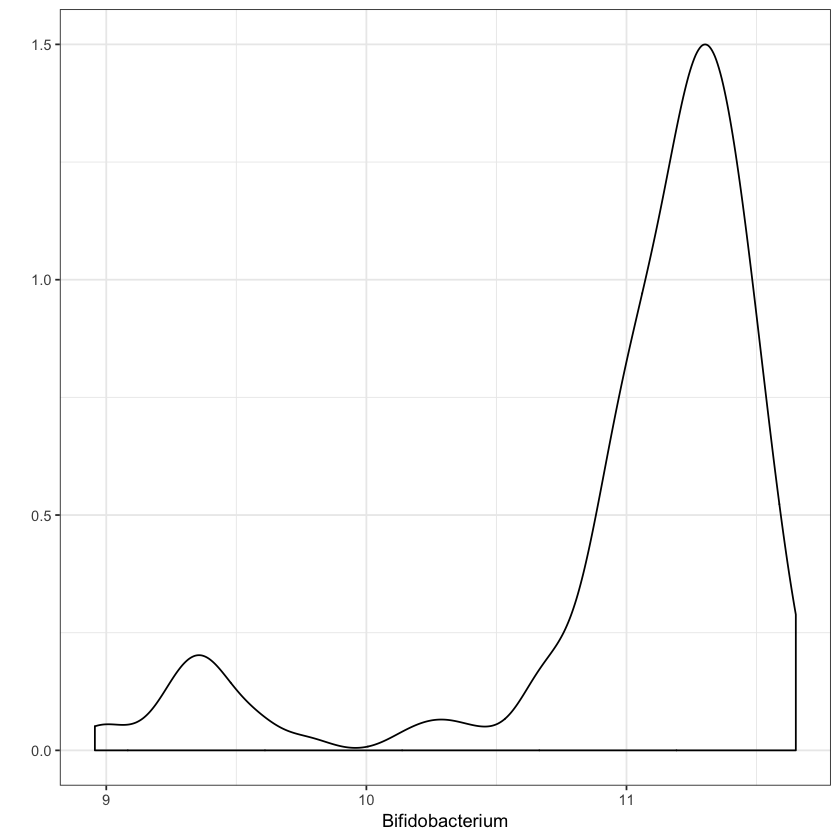

In [130]:
qplot(data = data, Bifidobacterium, geom = "density")

In [172]:
# set model options distributional
genus <- "Bifidobacterium"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(35)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 3)", class = "b", dpar = "sigma"),
            set_prior("exponential(40)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(35)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [173]:
cc_time_dg <- brmd_g()

In [174]:
cc_time_dt <- brmd_t()

In [175]:
cc_time_dsn <- brmd_sn()

In [176]:
source(here("R/bayesian_helper.R"))
# We can check visually how well the model predicts outcomes
# using the same predictors as in our training data.
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })


As expected, the models are all crap as far as I can tell. They predict to high and too low abundance  and the reason will be that the predictors cannot explain the bimodal distribution. The student t model converged easiest but look at the extreme outlier it can produce (you need to set upper and lower at 6 to see it. Maybe the non-distrubtional model (with fixed sigma) will even do a better job here?! I want to test this once...If there is a setting how to make the skew normal model work I would consider it ok but the predictors are just no explaining enought of the bimodal distribution...



In [177]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                             term    estimate  std.error        lower
1                     b_Intercept 11.26625969 0.03501374 11.208474937
2               b_sigma_Intercept -1.51765931 0.19144299 -1.833123094
3                      b_timepost -0.08491374 0.03370488 -0.138748110
4                         b_ccyes -0.04920222 0.05677072 -0.142782775
5                b_timepost:ccyes  0.09750654 0.05821973  0.001533371
6                b_sigma_timepost  0.06448400 0.18923998 -0.246163426
7                   b_sigma_ccyes  0.41665967 0.25415118  0.001076013
8          b_sigma_timepost:ccyes -0.52427361 0.29505191 -1.012584356
9        sd_subject_id__Intercept  0.12988608 0.03004106  0.077992604
10 sd_subject_id__sigma_Intercept  0.73862382 0.08117934  0.609084994
         upper
1  11.32317799
2  -1.20247412
3  -0.02907698
4   0.04296533
5   0.19271424
6   0.37898820
7   0.83950057
8  -0.03950090
9   0.17558144
10  0.87499190

[[2]]
                             term    estimate  std.error        lower
1                     b_Intercept 11.26624831 0.03464477 11.208635442
2               b_sigma_Intercept -2.18673398 0.25734823 -2.620223020
3                      b_timepost -0.08446976 0.03852156 -0.148784871
4                         b_ccyes -0.03242280 0.05579436 -0.125607067
5                b_timepost:ccyes  0.07443225 0.06211590 -0.028519114
6                b_sigma_timepost  0.19904763 0.32228458 -0.341800679
7                   b_sigma_ccyes  0.44564327 0.32469222 -0.080879282
8          b_sigma_timepost:ccyes -0.55080196 0.44173923 -1.278283410
9        sd_subject_id__Intercept  0.15014154 0.02557589  0.108158050
10 sd_subject_id__sigma_Intercept  0.02287083 0.02370676  0.001288581
         upper
1  11.32262660
2  -1.78039161
3  -0.02179838
4   0.05710755
5   0.17742442
6   0.71533640
7   0.97582268
8   0.17768005
9   0.19271774
10  0.06991014

[[3]]
                             term    estimate  std.error       lower
1                     b_Intercept 11.17139908 0.05233889 11.08345979
2               b_sigma_Intercept -1.20185147 0.18097939 -1.49895932
3                      b_timepost -0.07844934 0.05378662 -0.16489171
4                         b_ccyes -0.07634217 0.07271188 -0.19958745
5                b_timepost:ccyes  0.17219226 0.08661184  0.03581759
6                b_sigma_timepost  0.06670546 0.16518693 -0.20338797
7                   b_sigma_ccyes  0.29473602 0.21033767 -0.04541762
8          b_sigma_timepost:ccyes -0.44692047 0.24005290 -0.84127494
9        sd_subject_id__Intercept  0.03624316 0.03279052  0.00185264
10 sd_subject_id__sigma_Intercept  0.46014996 0.09244909  0.31042785
         upper
1  11.24680963
2  -0.90919213
3   0.01150442
4   0.03984259
5   0.31727702
6   0.33732949
7   0.64513286
8  -0.05452650
9   0.10409484
10  0.60972885

In [178]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

In [179]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

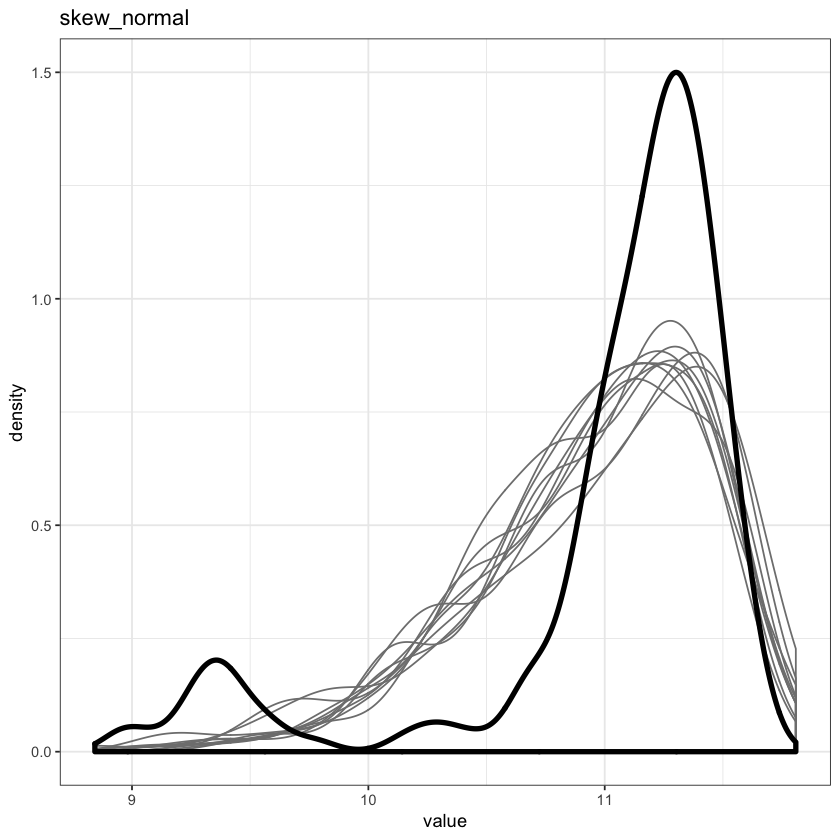

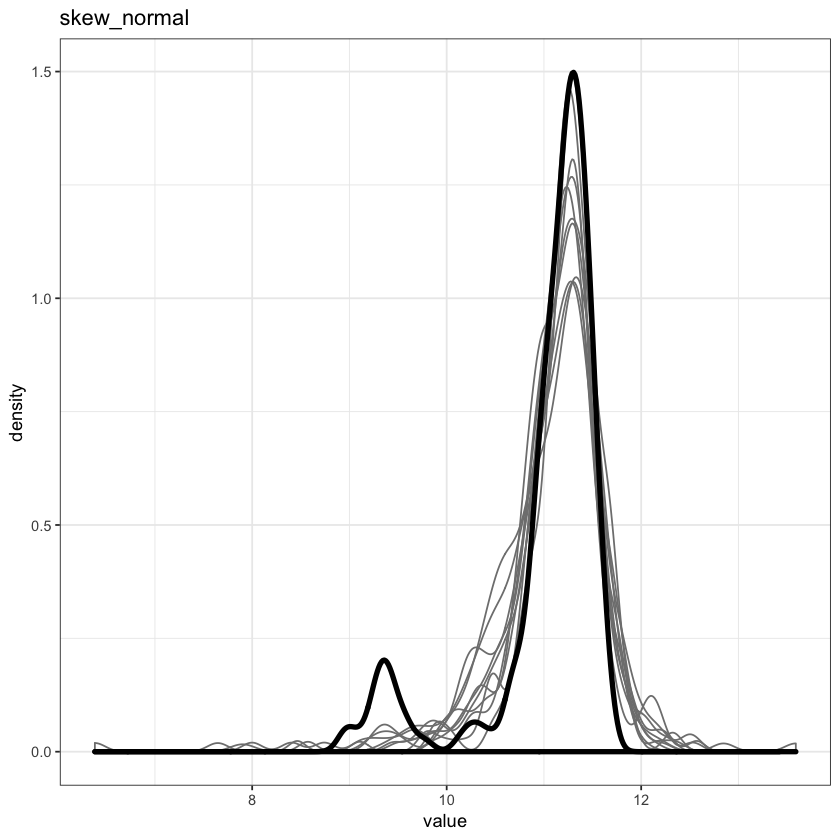

In [180]:
inspect_c2[[3]]
inspect_d2[[3]]

In [141]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                          term     estimate  std.error       lower       upper
1                  b_Intercept 11.050567594 0.08175860 10.91427219 11.18546714
2                   b_timepost -0.070543260 0.07967150 -0.20036837  0.06208743
3                      b_ccyes -0.083021782 0.11442375 -0.26779563  0.10610634
4             b_timepost:ccyes  0.228257231 0.11327295  0.04089324  0.41379240
5     sd_subject_id__Intercept  0.401735701 0.04443555  0.32802523  0.47365281
6                        sigma  0.395808091 0.03327678  0.34756772  0.45531660
7  r_subject_id[202,Intercept]  0.245512210 0.23310500 -0.13362693  0.63436026
8  r_subject_id[204,Intercept]  0.170427706 0.22754259 -0.20186717  0.54198346
9  r_subject_id[207,Intercept]  0.014858623 0.23028443 -0.36244688  0.39200330
10 r_subject_id[210,Intercept]  0.003871596 0.23604436 -0.39116081  0.39228527

[[2]]
                          term    estimate  std.error       lower       upper
1                  b_Intercept 11.26883875 0.03351442 11.21324411 11.32358938
2                   b_timepost -0.08227941 0.03759715 -0.14485539 -0.02120554
3                      b_ccyes -0.02530710 0.05079955 -0.10921015  0.05863064
4             b_timepost:ccyes  0.06852351 0.05746635 -0.02709001  0.15917033
5     sd_subject_id__Intercept  0.14298109 0.02913438  0.09812154  0.18525139
6                        sigma  0.12224229 0.02359356  0.08966067  0.16517177
7                           nu  1.17583820 0.14236782  1.01361367  1.45144646
8  r_subject_id[202,Intercept]  0.11883440 0.09122847 -0.03715461  0.26061619
9  r_subject_id[204,Intercept]  0.02811953 0.07472834 -0.09559308  0.14924317
10 r_subject_id[207,Intercept] -0.06015783 0.11400195 -0.26579726  0.11174284

[[3]]
                          term      estimate  std.error         lower
1                  b_Intercept 10.9692573547 0.05139372  10.884718890
2                   b_timepost -0.0598592962 0.06137496  -0.159495374
3                      b_ccyes -0.0131369298 0.06172446  -0.115321108
4             b_timepost:ccyes  0.0661485759 0.08772868  -0.076618383
5     sd_subject_id__Intercept  0.0251683282 0.02306656   0.001429569
6                        sigma  0.4959910755 0.02682638   0.453317613
7                        alpha -9.5616796955 1.99916923 -13.194927024
8  r_subject_id[202,Intercept]  0.0027841560 0.03215850  -0.042669909
9  r_subject_id[204,Intercept] -0.0002194328 0.03300270  -0.050934516
10 r_subject_id[207,Intercept] -0.0020369145 0.03377689  -0.056366988
         upper
1  11.05407692
2   0.04201775
3   0.08627988
4   0.21218717
5   0.07163593
6   0.54164522
7  -6.63623489
8   0.05552622
9   0.05044295
10  0.04717163


Indeed the skew normal with fixed sigma here would produce better model fit statistics I guess. Although it completely misses the second peak, it produces not as extreme outliers what about magnitude leading to smaler model accuracy statistics I guess. The other models further above would produce to many outliers to be better. The outliers must (?!) arise from overestimated error variance in the distributional models. Right now I would pick the simpler model. But lets add bf_ratio and hope that it explains maybe a litte of that bimodal distribution...



In [199]:
# set model options distributional
genus <- "Bifidobacterium"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc*bf_ratio + (1|subject_id))
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula <- bf(f)


# redefine fitting functions for imputed datasets distributional
brmd_g_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = gaussian(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = student(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}


# redefine fitting functions for imputed datasets constant
brm_g_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = gaussian(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = student(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn_imp <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc_bf")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

In [507]:
# impute data (I will need to check the right way later)
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, time, cc, bf_count, Enterococcus, Staphylococcus) %>%
    mice(m = 10, print = F)
complete(data_imp)

subject_id time cc  bf_count   Enterococcus Staphylococcus
1   207        post no   6.0000000  8.406051    7.914153      
2   388        post yes  0.0000000 10.211022    7.847963      
3   381        post yes  6.7600000  8.522135    7.958010      
4   283        post yes  5.0000000  8.836215    8.599344      
5   216        post no   7.0580000  8.803438    8.739628      
6   277        pre  yes  5.7908384  8.719565    8.363157      
7   373        post no   6.0000000  9.629113    8.137468      
8   245        pre  no   6.6850000 10.065508    9.134830      
9   311        pre  no   7.0909091  9.430302    8.584932      
10  213        pre  yes  6.0264386  9.717383    8.386637      
11  443        post no   5.0000000 10.037255    8.017792      
12  354        pre  yes  6.4883314  8.812034    8.906186      
13  422        post yes  0.0000000  9.729794    7.938319      
14  319        post yes  0.0000000  9.164080    8.187373      
15  233        pre  yes  0.4668534  9.350332    8.592924      
16  309        pre  no   2.6055305  8.666390    8.035334      
17  259        pre  no   7.1813285  9.528859    9.392545      
18  264        pre  yes  5.6805659  8.581759    8.173280      
19  449        post no   6.0740000  9.076620    8.999144      
20  431        pre  yes  4.9272116  9.531563    8.212453      
21  269        pre  yes 11.0187144  8.627750    8.270307      
22  204        pre  no   2.1286660  8.572836    8.112183      
23  202        pre  yes  7.5000000  8.689138    8.722969      
24  308        post no   5.0000000  8.719488    9.193088      
25  321        post yes  5.1000000 10.854101    8.840162      
26  338        post yes  6.3720000  8.601311    8.249229      
27  392        pre  yes  7.3263571  8.499850    7.960470      
28  322        pre  no   8.9732167  9.223965    8.074018      
29  392        post yes  4.8000000  8.658923    7.922216      
30  421        post yes  5.0000000  9.090506    8.236756      
⋮   ⋮          ⋮    ⋮   ⋮          ⋮            ⋮             
167 297        pre  no   4.219031   8.769356    8.693023      
168 245        post no   5.844000  10.198715    8.357211      
169 260        post no   5.358000  10.667382    8.027993      
170 397        pre  no   5.207486   8.853403    9.193161      
171 448        post yes  0.000000  10.663903    8.643465      
172 298        post no   0.000000   9.889418    8.042801      
173 408        post no   0.000000  10.720592    8.030082      
174 391        post no   0.000000   9.178045    8.014718      
175 350        post yes  0.000000  10.390150    8.072773      
176 275        post yes  0.000000  10.513403    8.197228      
177 320        post no   0.000000   8.600731    7.910217      
178 381        pre  yes  7.735783   8.471138    8.035612      
179 210        pre  yes  0.000000  10.101560    7.937024      
180 349        post no   6.600000   8.924706    8.782085      
181 273        post yes 10.000000   8.643613    7.948626      
182 322        post no   7.300000  10.149944    7.874128      
183 254        post yes  6.400000  10.247815    7.898352      
184 260        pre  no   6.000000   8.482695    8.726749      
185 316        post yes  6.300000   8.851455    8.044003      
186 234        pre  no   0.000000   8.471407    8.107192      
187 336        pre  yes  6.765206  10.754033    8.293664      
188 313        pre  no   6.871838   8.904831    8.308980      
189 382        pre  yes  5.665181  10.144325    8.631727      
190 413        pre  yes  5.750000  10.312632    9.062955      
191 284        post yes  0.000000   9.047397    8.025698      
192 297        post no   0.000000   9.510827    8.481637      
193 437        pre  yes  5.405405   9.621850    8.613361      
194 435        pre  no   3.660499   9.614006    8.137064      
195 367        pre  no   7.001795   8.774859    9.080643      
196 274        pre  yes  0.000000  11.072600    8.286075

In [201]:
cc_time_bf_dg <- brmd_g_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [202]:
cc_time_bf_dt <- brmd_t_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [203]:
cc_time_bf_dsn <- brmd_sn_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [204]:
source(here("R/bayesian_helper.R"))
model_list <- list(cc_time_bf_dg, cc_time_bf_dt, cc_time_bf_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [205]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                        term    estimate std.error       lower      upper
1                b_Intercept 11.23304790 0.1037366 11.05540708 11.3831281
2          b_sigma_Intercept -1.49605021 0.5210262 -2.34334578 -0.6294052
3                 b_timepost -0.04451471 0.1006745 -0.18941388  0.1314075
4                    b_ccyes -0.26424583 0.2543967 -0.73105069  0.1129586
5                 b_bf_ratio  0.04110571 0.1149394 -0.13330807  0.2345217
6           b_timepost:ccyes  0.30055043 0.2527296 -0.08440998  0.7541582
7        b_timepost:bf_ratio -0.06218716 0.1243734 -0.27610987  0.1306901
8           b_ccyes:bf_ratio  0.24316516 0.2688344 -0.16351668  0.7363142
9  b_timepost:ccyes:bf_ratio -0.21873811 0.2714707 -0.70201720  0.2062585
10          b_sigma_timepost -0.43310663 0.5198478 -1.33086792  0.3943159

[[2]]
                        term    estimate  std.error       lower       upper
1                b_Intercept 11.23124554 0.09384090 11.06868590 11.37414328
2          b_sigma_Intercept -2.24210021 0.65665383 -3.37669415 -1.22633813
3                 b_timepost -0.04525093 0.08635704 -0.17236494  0.10943000
4                    b_ccyes -0.27479874 0.25224961 -0.71117923  0.11202638
5                 b_bf_ratio  0.04263882 0.10268943 -0.11198594  0.22277819
6           b_timepost:ccyes  0.31369219 0.25144391 -0.07410183  0.74759402
7        b_timepost:bf_ratio -0.07219243 0.11058221 -0.26051845  0.09802318
8           b_ccyes:bf_ratio  0.26041249 0.26616014 -0.14544841  0.72083468
9  b_timepost:ccyes:bf_ratio -0.23276886 0.26868762 -0.69627096  0.18144705
10          b_sigma_timepost -0.80937675 0.91579809 -2.36042343  0.65997066

[[3]]
                        term    estimate std.error       lower       upper
1                b_Intercept 11.09463037 0.1819268 10.75518898 11.31964419
2          b_sigma_Intercept -1.16085230 0.4897880 -1.94228436 -0.31402288
3                 b_timepost  0.03629795 0.1706608 -0.18917408  0.34911764
4                    b_ccyes -0.37855141 0.2730666 -0.84379636  0.04870309
5                 b_bf_ratio  0.06550281 0.1889218 -0.20096473  0.40495578
6           b_timepost:ccyes  0.33882331 0.2842604 -0.12797606  0.81383000
7        b_timepost:bf_ratio -0.16842809 0.2086839 -0.53904167  0.12777267
8           b_ccyes:bf_ratio  0.36998260 0.2993289 -0.09530694  0.87963427
9  b_timepost:ccyes:bf_ratio -0.15331808 0.3270643 -0.68092584  0.38454872
10          b_sigma_timepost -0.33621656 0.4399461 -1.06365924  0.37856385


Having seen the example for Bifidobacterium, obviously the question arises if the simpler models maybe do a better job for the other genus as well where see similar issues with regard to outliers. On the one hand, I might now try to overfit the training data if I say I want to avoid those completely but on the other hand the distributions really look as if an outlier to one side is extremely unlikely and therefore I would want the model not reflect this as well.



In [206]:
cc_time_bf_g <- brm_g_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [207]:
cc_time_bf_t <- brm_t_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [208]:
cc_time_bf_sn <- brm_sn_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [209]:
model_list <- list(cc_time_bf_g, cc_time_bf_t, cc_time_bf_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

Warning message:
“Removed 47 rows containing non-finite values (stat_density).”

Warning message:
“Removed 153 rows containing non-finite values (stat_density).”

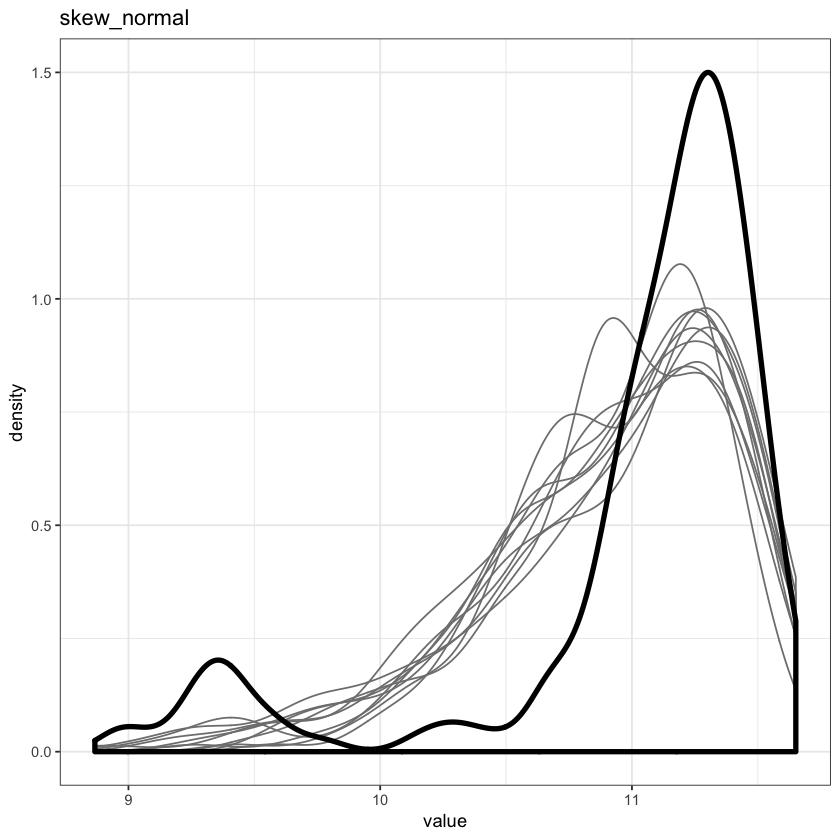

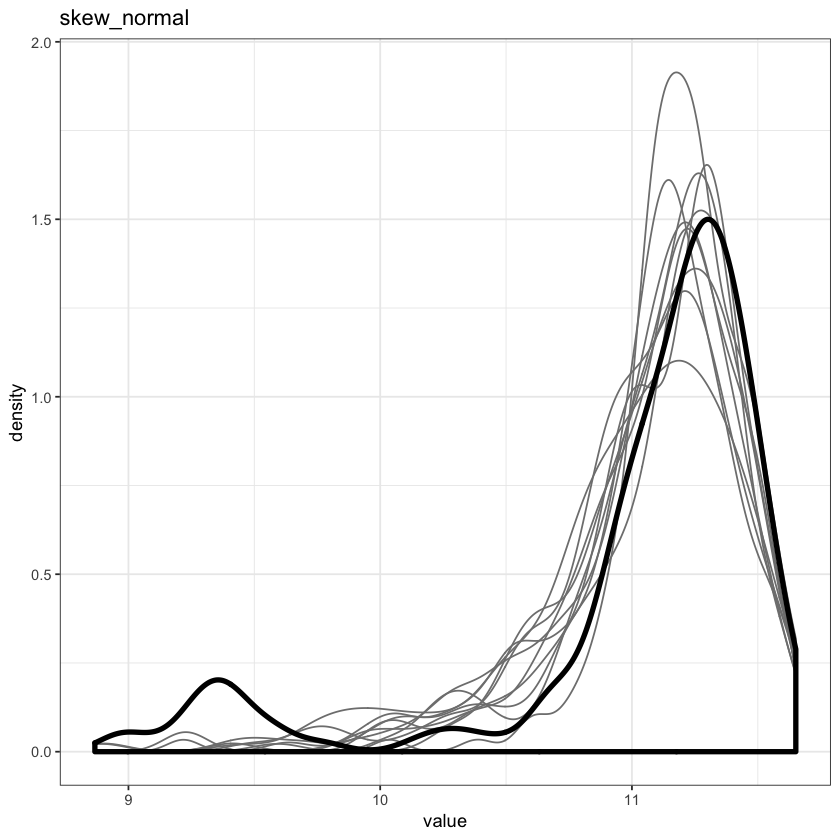

In [210]:
inspect_c2[[3]]
inspect_d2[[3]]

In [211]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                        term    estimate  std.error      lower      upper
1                b_Intercept 10.98140128 0.21064360 10.6370470 11.3306633
2                 b_timepost  0.08400670 0.20111724 -0.2461574  0.4117032
3                    b_ccyes -0.28403500 0.27657506 -0.7468271  0.1674733
4                 b_bf_ratio  0.08563036 0.24210234 -0.3254207  0.4779472
5           b_timepost:ccyes  0.27585051 0.26689720 -0.1584221  0.7196973
6        b_timepost:bf_ratio -0.22809911 0.23982315 -0.6246187  0.1717328
7           b_ccyes:bf_ratio  0.26051035 0.31914539 -0.2628713  0.7893230
8  b_timepost:ccyes:bf_ratio -0.01580639 0.31905256 -0.5532819  0.4985877
9   sd_subject_id__Intercept  0.39762146 0.04484067  0.3244572  0.4691109
10                     sigma  0.39869112 0.03360906  0.3487411  0.4580645

[[2]]
                        term    estimate  std.error       lower       upper
1                b_Intercept 11.23423584 0.08921632 11.08164975 11.37729222
2                 b_timepost -0.05611159 0.08776255 -0.19632280  0.09154421
3                    b_ccyes -0.10185937 0.14233775 -0.33558967  0.12492693
4                 b_bf_ratio  0.04015914 0.10268907 -0.12563858  0.21303720
5           b_timepost:ccyes  0.18806770 0.14167940 -0.03996116  0.41940831
6        b_timepost:bf_ratio -0.02943917 0.11018499 -0.21543120  0.14918834
7           b_ccyes:bf_ratio  0.09061082 0.15977015 -0.16126848  0.35650270
8  b_timepost:ccyes:bf_ratio -0.15411044 0.16700017 -0.42724708  0.11216269
9   sd_subject_id__Intercept  0.14666678 0.02712090  0.10384478  0.18738121
10                     sigma  0.12264263 0.02270665  0.09019572  0.16304709

[[3]]
                        term     estimate  std.error        lower      upper
1                b_Intercept 10.938750695 0.12591365 10.757330977 11.1662032
2                 b_timepost -0.057393318 0.14818481 -0.315609907  0.1678244
3                    b_ccyes -0.092603135 0.15377272 -0.355032083  0.1500397
4                 b_bf_ratio  0.042165375 0.13799087 -0.205782938  0.2441000
5           b_timepost:ccyes  0.206571242 0.19054953 -0.098085705  0.5244572
6        b_timepost:bf_ratio  0.005051323 0.16897214 -0.262251157  0.2919967
7           b_ccyes:bf_ratio  0.097876558 0.17520013 -0.179281071  0.3971585
8  b_timepost:ccyes:bf_ratio -0.188783316 0.22306834 -0.564329592  0.1750066
9   sd_subject_id__Intercept  0.025169450 0.02270328  0.001422417  0.0717366
10                     sigma  0.497584949 0.02709896  0.454747225  0.5428561

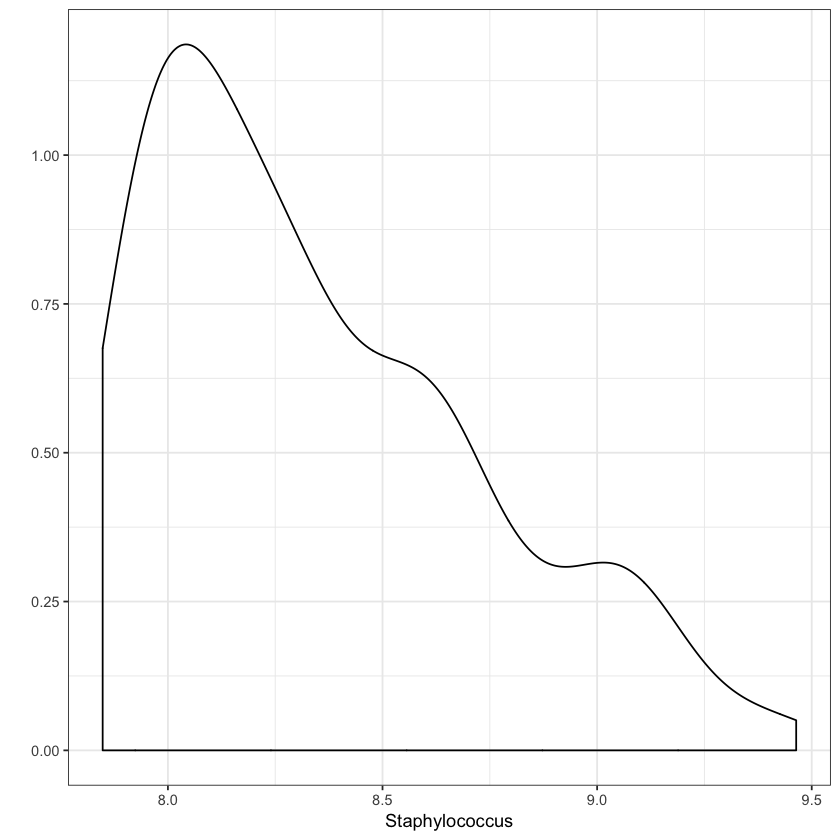

In [212]:
qplot(data = data, Staphylococcus, geom = "density")

In [213]:
# set model options distributional
genus <- "Staphylococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 3)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 3)", class = "b", dpar = "sigma"),
            set_prior("exponential(60)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [214]:
cc_time_dg <- brmd_g()

In [215]:
cc_time_dt <- brmd_t()

In [216]:
cc_time_dsn <- brmd_sn()

Warning message:
“Removed 122 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 122 rows containing missing values (geom_point).”Warning message:
“Removed 127 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 127 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

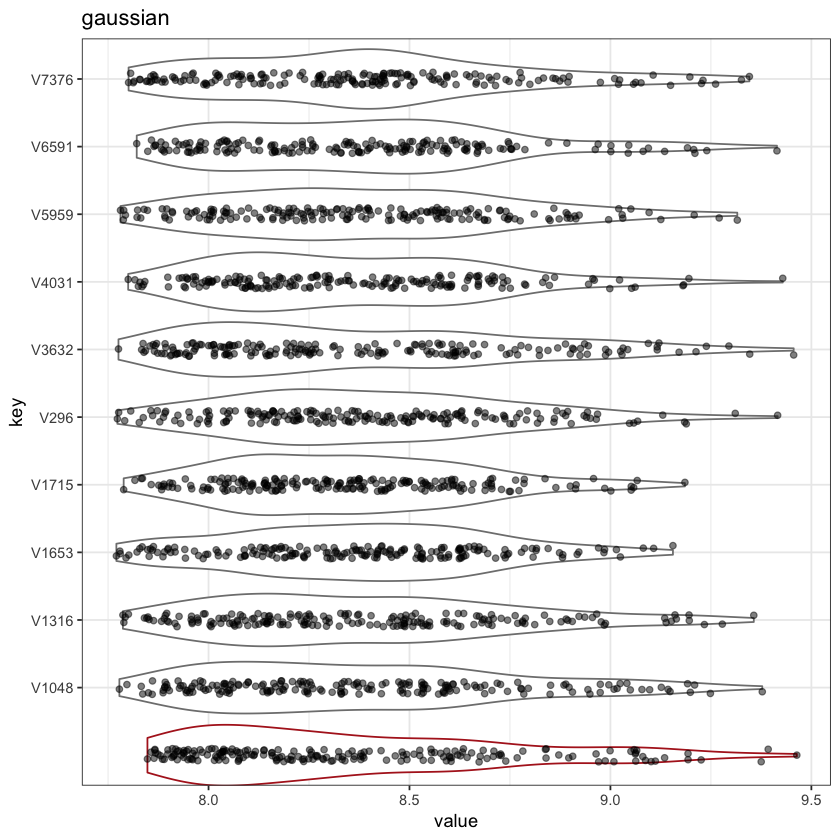

Warning message:
“Removed 35 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 35 rows containing missing values (geom_point).”

[[1]]

[[2]]

[[3]]


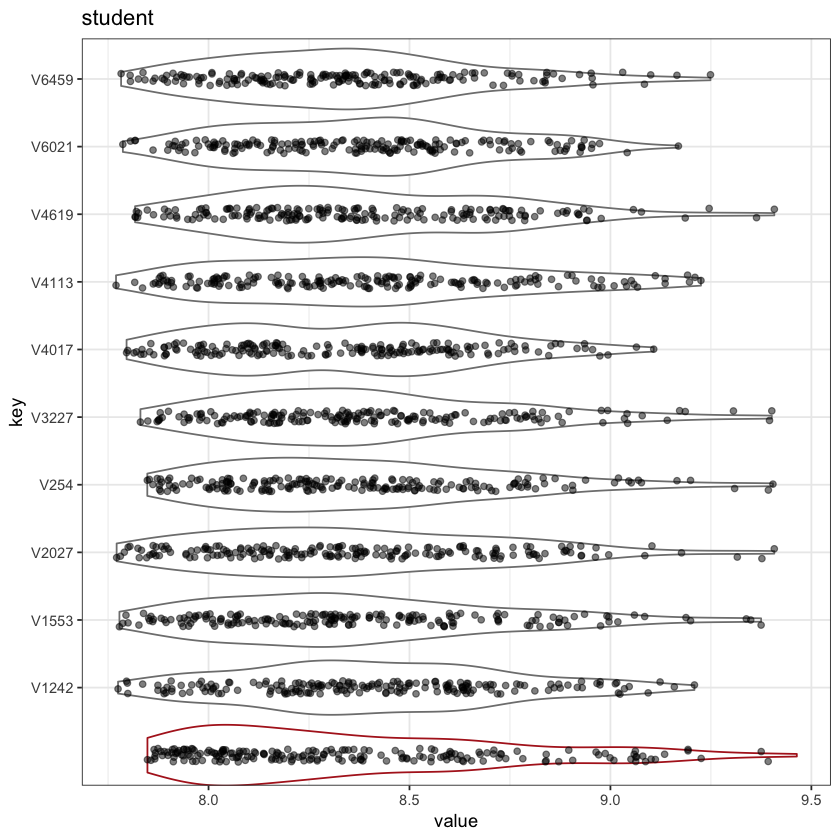

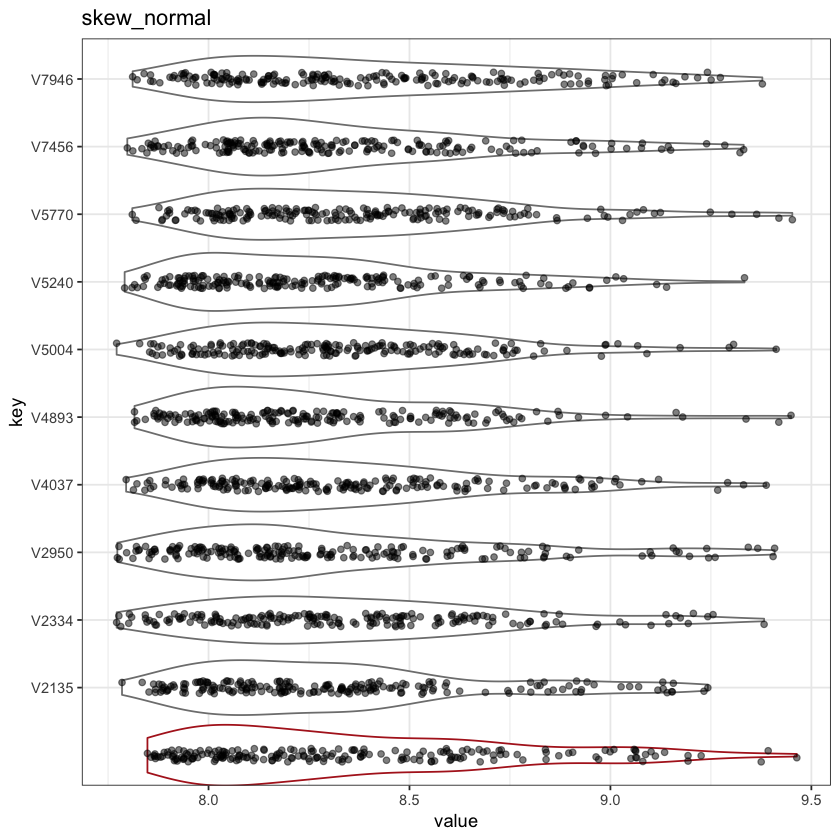

In [217]:
model_list <- list(cc_time_dg, cc_time_dt, cc_time_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [218]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                             term    estimate  std.error        lower
1                     b_Intercept  8.44394458 0.06040542  8.344052315
2               b_sigma_Intercept -1.12009702 0.13190541 -1.340461936
3                      b_timepost -0.16155123 0.05527983 -0.251510296
4                         b_ccyes -0.01697602 0.08020531 -0.146670704
5                b_timepost:ccyes -0.02390051 0.07140570 -0.142052228
6                b_sigma_timepost -0.61879566 0.53073343 -1.549121349
7                   b_sigma_ccyes -0.26235316 0.20249413 -0.603226219
8          b_sigma_timepost:ccyes  0.05871823 0.83241830 -1.542375348
9        sd_subject_id__Intercept  0.26469330 0.02969630  0.217042582
10 sd_subject_id__sigma_Intercept  0.02250727 0.02292040  0.001028081
         upper
1   8.54323845
2  -0.90148624
3  -0.07004266
4   0.11593964
5   0.09395144
6  -0.08560306
7   0.06316571
8   1.11382850
9   0.31368875
10  0.06903908

[[2]]
                             term    estimate  std.error         lower
1                     b_Intercept  8.43061482 0.06086347  8.3322643178
2               b_sigma_Intercept -1.18885282 0.14753576 -1.4405629564
3                      b_timepost -0.15226250 0.05632630 -0.2450386810
4                         b_ccyes -0.01185605 0.07903203 -0.1421501617
5                b_timepost:ccyes -0.02812063 0.07111723 -0.1449116030
6                b_sigma_timepost -0.53066390 0.33453659 -1.1431886717
7                   b_sigma_ccyes -0.27558129 0.21416828 -0.6311788399
8          b_sigma_timepost:ccyes  0.14293544 0.48297465 -0.6135313063
9        sd_subject_id__Intercept  0.25690721 0.02674174  0.2141687729
10 sd_subject_id__sigma_Intercept  0.01697390 0.01698266  0.0008639081
         upper
1   8.53169726
2  -0.95108943
3  -0.05965310
4   0.11987509
5   0.08946700
6  -0.06936370
7   0.06719689
8   0.94343421
9   0.30153909
10  0.05137469

[[3]]
                             term    estimate  std.error         lower
1                     b_Intercept  8.45941835 0.05974242  8.3698027512
2               b_sigma_Intercept -0.85821438 0.11011252 -1.0303775731
3                      b_timepost -0.16624026 0.07518730 -0.2891247937
4                         b_ccyes -0.04941610 0.08265831 -0.1848553868
5                b_timepost:ccyes  0.00978563 0.10284820 -0.1578112598
6                b_sigma_timepost -0.24340943 0.15237410 -0.4921499775
7                   b_sigma_ccyes -0.06199234 0.14959921 -0.3114070298
8          b_sigma_timepost:ccyes -0.03658943 0.21128862 -0.3818586682
9        sd_subject_id__Intercept  0.01727659 0.02305390  0.0007699069
10 sd_subject_id__sigma_Intercept  0.01532178 0.01504347  0.0008304012
          upper
1   8.565085134
2  -0.673953443
3  -0.045749682
4   0.087270605
5   0.178700445
6   0.005717866
7   0.184075590
8   0.304408489
9   0.052223127
10  0.045490714

In [219]:
cc_time_g <- brm_g()
cc_time_t <- brm_t()
cc_time_sn <- brm_sn()

Warning message:
“Removed 118 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 118 rows containing missing values (geom_point).”Warning message:
“Removed 161 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 161 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

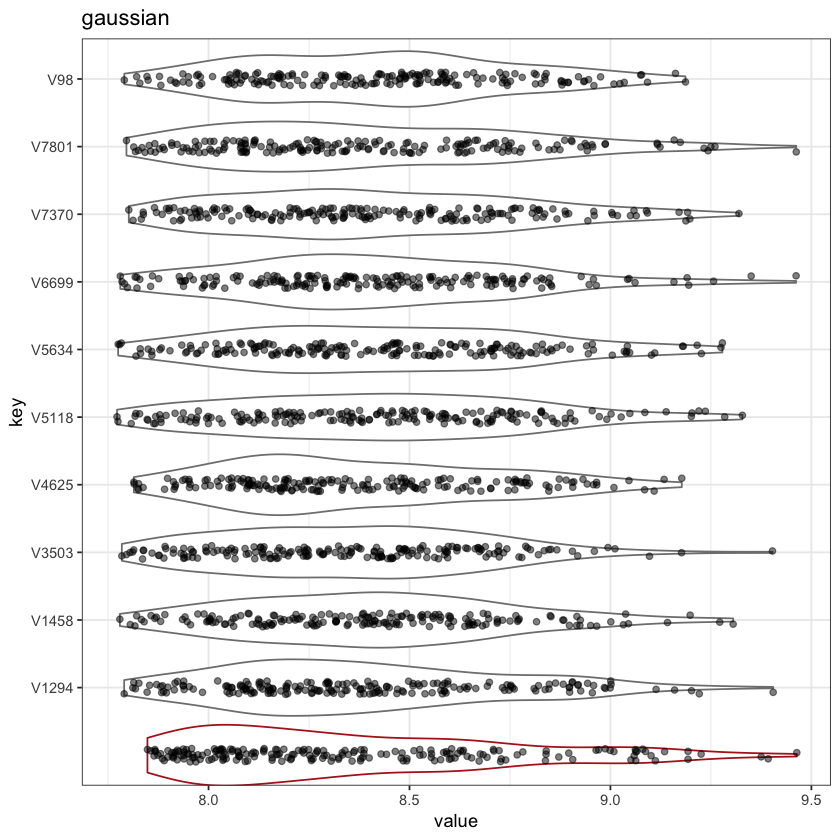

Warning message:
“Removed 31 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 31 rows containing missing values (geom_point).”

[[1]]

[[2]]

[[3]]


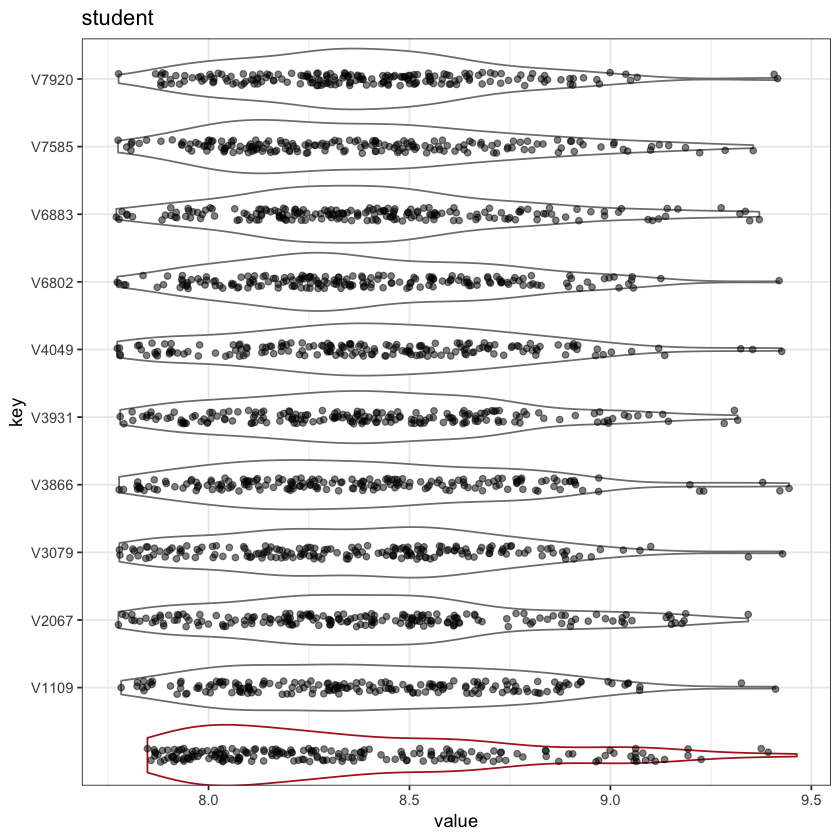

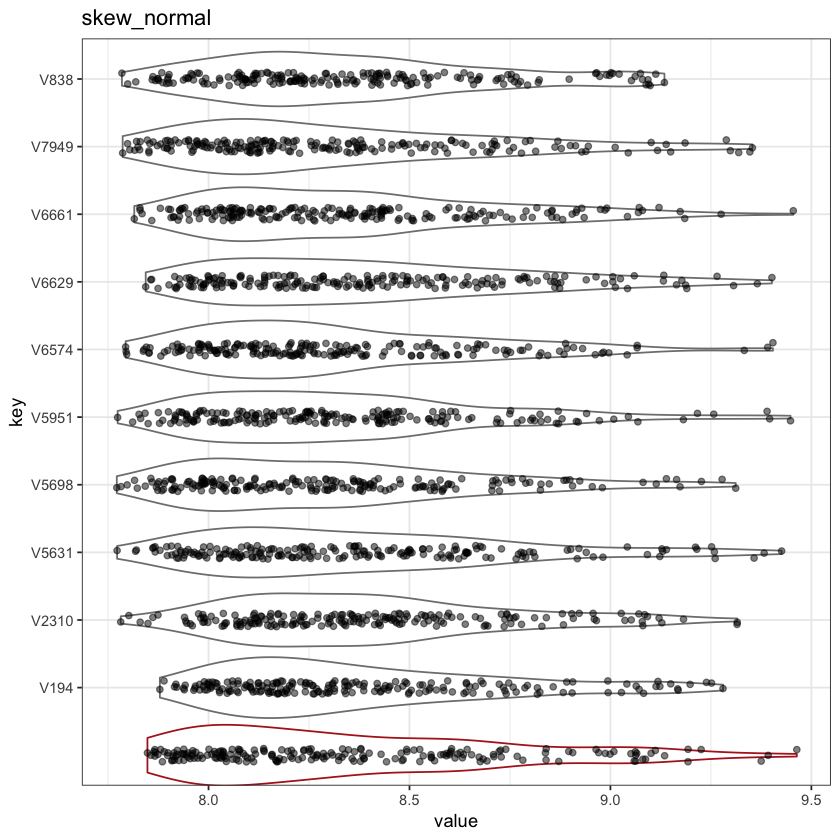

In [220]:
model_list <- list(cc_time_g, cc_time_t, cc_time_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

Warning message:
“Removed 32 rows containing non-finite values (stat_density).”

Warning message:
“Removed 43 rows containing non-finite values (stat_density).”

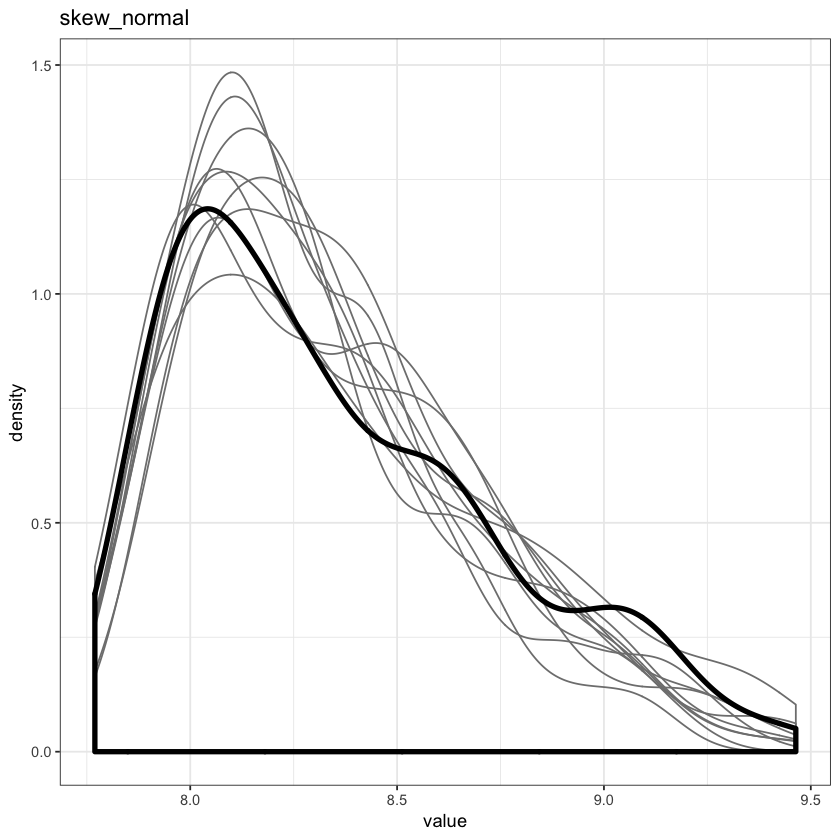

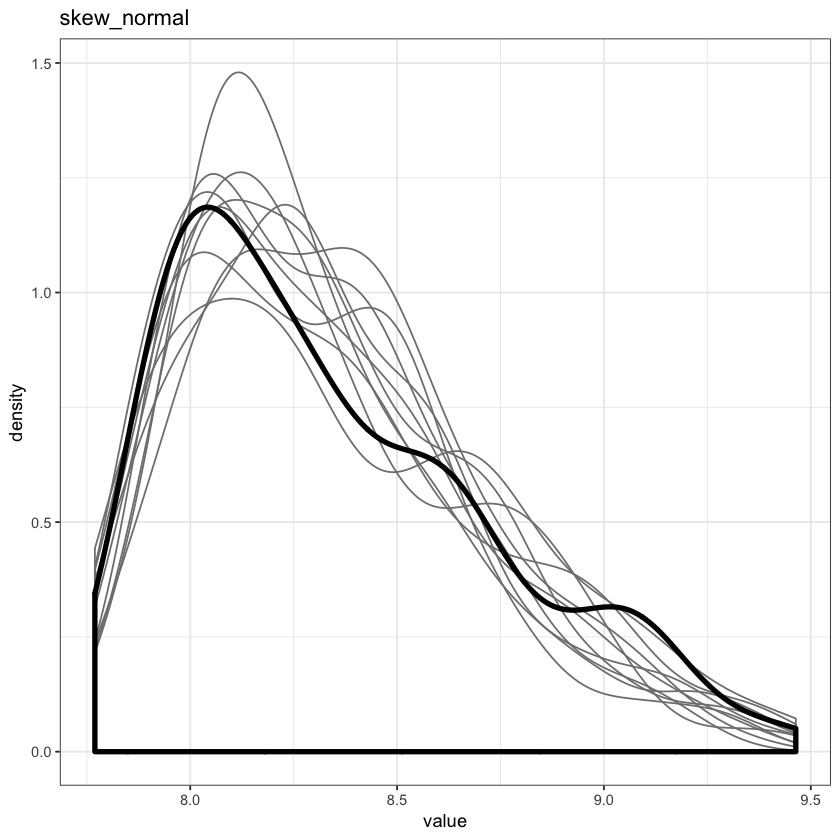

In [221]:
inspect_c2[[3]]
inspect_d2[[3]]

In [222]:
lapply(model_list, function(model){
    broom::tidy(model)[1:10,]
    })

[[1]]
                          term    estimate  std.error      lower       upper
1                  b_Intercept  8.44454466 0.05252035  8.3589774  8.53055025
2                   b_timepost -0.16107042 0.04942152 -0.2438082 -0.08024841
3                      b_ccyes -0.01861021 0.07293993 -0.1379478  0.10056080
4             b_timepost:ccyes -0.02507999 0.06891280 -0.1398797  0.08862903
5     sd_subject_id__Intercept  0.26376828 0.02680985  0.2200052  0.30873908
6                        sigma  0.24508731 0.01921460  0.2157676  0.27880890
7  r_subject_id[202,Intercept]  0.10933267 0.15318530 -0.1479186  0.35963112
8  r_subject_id[204,Intercept] -0.18265715 0.14751797 -0.4285691  0.05590923
9  r_subject_id[207,Intercept] -0.27683717 0.14766162 -0.5178100 -0.03470565
10 r_subject_id[210,Intercept] -0.27703247 0.15007349 -0.5224060 -0.02953934

[[2]]
                          term    estimate   std.error      lower       upper
1                  b_Intercept  8.43037548  0.05219083  8.3429303  8.51602470
2                   b_timepost -0.15223637  0.04983967 -0.2344360 -0.07183766
3                      b_ccyes -0.01001748  0.07258316 -0.1270866  0.11048799
4             b_timepost:ccyes -0.02991579  0.06958922 -0.1435685  0.08558446
5     sd_subject_id__Intercept  0.26482947  0.02661602  0.2217160  0.30974601
6                        sigma  0.22813265  0.02210397  0.1930088  0.26528371
7                           nu 21.77591407 13.78736124  6.1361025 48.67718251
8  r_subject_id[202,Intercept]  0.11020875  0.14509727 -0.1315305  0.34550982
9  r_subject_id[204,Intercept] -0.18117569  0.14301289 -0.4128272  0.05464267
10 r_subject_id[207,Intercept] -0.28219544  0.14390380 -0.5113234 -0.04243043

[[3]]
                          term     estimate  std.error         lower
1                  b_Intercept  8.398837953 0.03803244  8.3367871658
2                   b_timepost -0.074843281 0.04555122 -0.1517568233
3                      b_ccyes -0.024392515 0.04655578 -0.0997521334
4             b_timepost:ccyes  0.013946296 0.06392230 -0.0929311382
5     sd_subject_id__Intercept  0.020780614 0.02907076  0.0008506729
6                        sigma  0.364386920 0.02392792  0.3277067075
7                        alpha  9.370909300 2.20638453  6.1194026700
8  r_subject_id[202,Intercept]  0.004481361 0.03276517 -0.0312944059
9  r_subject_id[204,Intercept] -0.001162205 0.03033285 -0.0387871375
10 r_subject_id[207,Intercept] -0.008113135 0.03584129 -0.0591270651
          upper
1   8.462980198
2  -0.002616167
3   0.052870573
4   0.117763028
5   0.067796913
6   0.400323354
7  13.303478554
8   0.051103217
9   0.037177423
10  0.023921637

In [223]:
# set model options distributional
genus <- "Staphylococcus"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(50)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# set model options constant
f <- as.formula(glue("{genus} ~ 1 + time*cc*bf_ratio + (1|subject_id)"))
formula <- bf(f)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(70)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)

In [224]:
# impute data (I will need to check the right way later)
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, time, cc, bf_ratio, genus) %>%
    mice(m = 5, print = F)

In [225]:
cc_time_bf_dg <- brmd_g_imp()
cc_time_bf_dt <- brmd_t_imp()
cc_time_bf_dsn <- brmd_sn_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [226]:
source(here("R/bayesian_helper.R"))
model_list <- list(cc_time_bf_dg, cc_time_bf_dt, cc_time_bf_dsn)
inspect_d <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_d2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

In [227]:
lapply(model_list, function(model){
    broom::tidy(model)[1:14,]
    })

[[1]]
                             term    estimate  std.error        lower
1                     b_Intercept  8.14802131 0.15898827  7.889010464
2               b_sigma_Intercept -1.08135892 0.13048385 -1.297887176
3                      b_timepost -0.05388247 0.15086195 -0.300457850
4                         b_ccyes  0.02372986 0.19035515 -0.288424443
5                      b_bf_ratio  0.36647418 0.18383158  0.068074906
6                b_timepost:ccyes -0.01749856 0.17910004 -0.315893427
7             b_timepost:bf_ratio -0.06064386 0.17624929 -0.351961177
8                b_ccyes:bf_ratio -0.04152533 0.22044557 -0.403977631
9       b_timepost:ccyes:bf_ratio -0.04982037 0.21066638 -0.400562676
10               b_sigma_timepost -0.55151153 0.34101174 -1.121608674
11                  b_sigma_ccyes -0.30139680 0.19152559 -0.614660344
12         b_sigma_timepost:ccyes  0.25548336 0.46530006 -0.410651252
13       sd_subject_id__Intercept  0.22228942 0.03480153  0.171312719
14 sd_subject_id__sigma_Intercept  0.02040749 0.01993797  0.001188819
         upper
1   8.40685033
2  -0.86383602
3   0.19384804
4   0.34100096
5   0.67155087
6   0.27702738
7   0.23034393
8   0.31771982
9   0.30394352
10 -0.13347460
11  0.01424413
12  0.96485251
13  0.27161663
14  0.06036309

[[2]]
                             term    estimate  std.error         lower
1                     b_Intercept  8.14088159 0.15440744  7.8889739505
2               b_sigma_Intercept -1.14708441 0.14556623 -1.3901092604
3                      b_timepost -0.05028728 0.14637209 -0.2948744729
4                         b_ccyes  0.01440345 0.18832902 -0.3033747074
5                      b_bf_ratio  0.35943856 0.18064155  0.0581101495
6                b_timepost:ccyes -0.03054965 0.17688080 -0.3174257193
7             b_timepost:bf_ratio -0.04599056 0.17458968 -0.3277598317
8                b_ccyes:bf_ratio -0.02084629 0.21893535 -0.3765458285
9       b_timepost:ccyes:bf_ratio -0.05003470 0.20968805 -0.3976288401
10               b_sigma_timepost -0.57210420 0.27947362 -1.0657474619
11                  b_sigma_ccyes -0.31985004 0.20263255 -0.6545949798
12         b_sigma_timepost:ccyes  0.27118183 0.40178983 -0.3785185509
13       sd_subject_id__Intercept  0.22371970 0.02691596  0.1791036361
14 sd_subject_id__sigma_Intercept  0.02015748 0.02004373  0.0009998636
         upper
1   8.39707346
2  -0.91684660
3   0.18994500
4   0.32099914
5   0.64808930
6   0.26309265
7   0.24101267
8   0.34373165
9   0.28708117
10 -0.16458618
11  0.01170438
12  0.93204899
13  0.26724482
14  0.05947225

[[3]]
                             term     estimate  std.error        lower
1                     b_Intercept  8.219351833 0.14157390  7.973281671
2               b_sigma_Intercept -0.919621697 0.12734849 -1.133298290
3                      b_timepost -0.011726017 0.15340659 -0.253924493
4                         b_ccyes -0.029324336 0.17672958 -0.311148951
5                      b_bf_ratio  0.291404942 0.15586503  0.055298179
6                b_timepost:ccyes -0.017839102 0.19224151 -0.336463552
7             b_timepost:bf_ratio -0.151767367 0.17157390 -0.445027695
8                b_ccyes:bf_ratio -0.003416138 0.19612829 -0.327679692
9       b_timepost:ccyes:bf_ratio  0.002440900 0.21376302 -0.344650639
10               b_sigma_timepost -0.248026196 0.16602846 -0.525566103
11                  b_sigma_ccyes -0.116751244 0.17093273 -0.407921148
12         b_sigma_timepost:ccyes -0.004295648 0.23130184 -0.378823585
13       sd_subject_id__Intercept  0.047839032 0.05615628  0.001289929
14 sd_subject_id__sigma_Intercept  0.018865217 0.01849220  0.000996760
         upper
1   8.44063819
2  -0.71462508
3   0.25011136
4   0.26326196
5   0.56662939
6   0.28822105
7   0.11516432
8   0.32042898
9   0.35232569
10  0.01160156
11  0.14987743
12  0.37574534
13  0.17616538
14  0.05651674

In [228]:
cc_time_bf_g <- brm_g_imp()
cc_time_bf_t <- brm_t_imp()
cc_time_bf_sn <- brm_sn_imp()

Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 1
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5


In [229]:
model_list <- list(cc_time_bf_g, cc_time_bf_t, cc_time_bf_sn)
inspect_c <- 
    lapply(model_list, function(x) {
        pp_plot_v2(x, 10, genus, lower = 0.01, upper = 0)
    })
inspect_c2 <- 
    lapply(model_list, function(x) {
        pp_plot(x, 10, genus, lower = 0.01, upper = 0)
    })

Warning message:
“Removed 40 rows containing non-finite values (stat_density).”

Warning message:
“Removed 50 rows containing non-finite values (stat_density).”

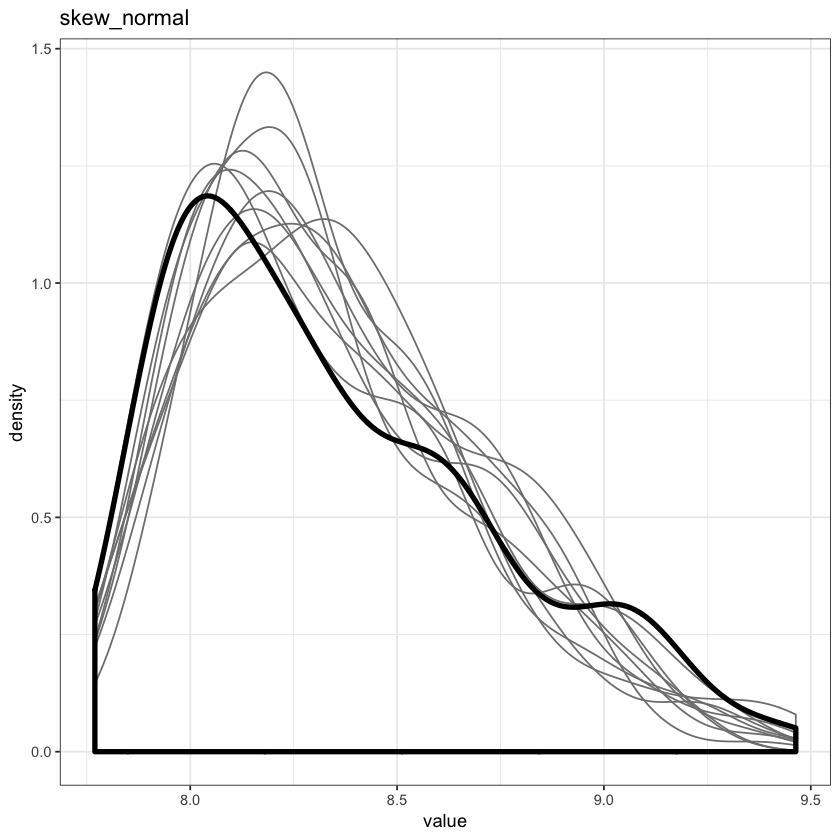

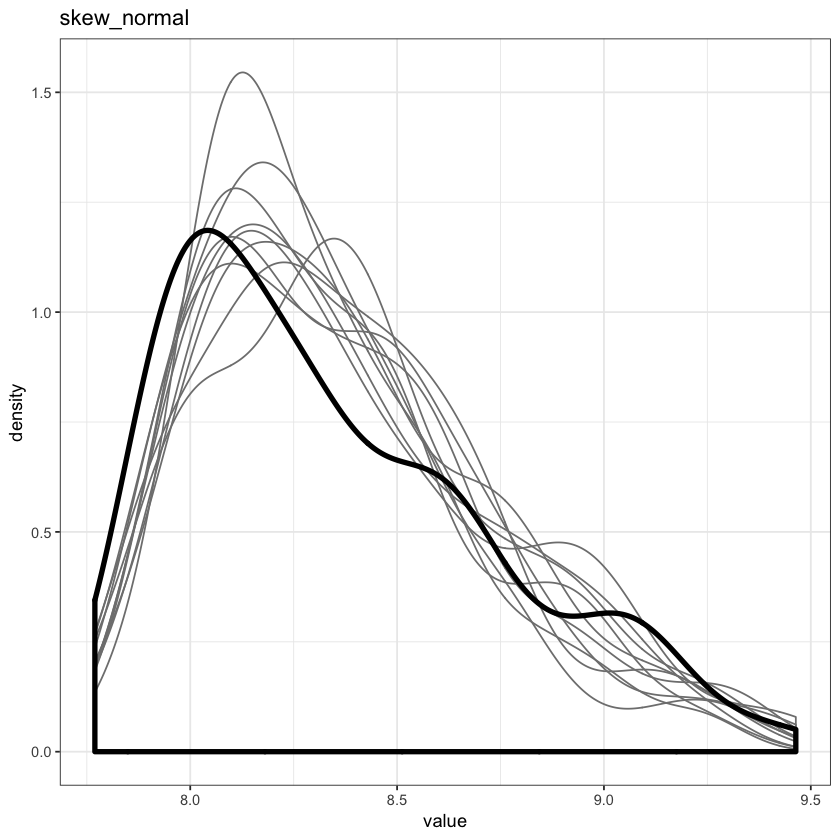

In [230]:
inspect_c2[[3]]
inspect_d2[[3]]

In [231]:
lapply(model_list, function(model){
    broom::tidy(model)[1:14,]
    })

[[1]]
                          term    estimate  std.error        lower      upper
1                  b_Intercept  8.13571671 0.13408294  7.916179935 8.35262985
2                   b_timepost -0.04485510 0.13991663 -0.273143821 0.18535381
3                      b_ccyes  0.01096219 0.17536568 -0.275867884 0.29946109
4                   b_bf_ratio  0.38451612 0.15551330  0.130934452 0.63797882
5             b_timepost:ccyes -0.01844171 0.18568261 -0.321067851 0.28626883
6          b_timepost:bf_ratio -0.06463499 0.16818795 -0.344727025 0.20976678
7             b_ccyes:bf_ratio -0.02700781 0.20275484 -0.362571522 0.30570328
8    b_timepost:ccyes:bf_ratio -0.05459777 0.22117630 -0.418282993 0.30614575
9     sd_subject_id__Intercept  0.16343648 0.08088113  0.005462864 0.25043649
10                       sigma  0.28540327 0.04494188  0.230282648 0.37026974
11 r_subject_id[202,Intercept]  0.03403998 0.12268476 -0.164165678 0.24944268
12 r_subject_id[204,Intercept] -0.03466974 0.12714262 -0.259684126 0.16826099
13 r_subject_id[207,Intercept] -0.20928711 0.16963529 -0.496044992 0.01083067
14 r_subject_id[210,Intercept] -0.07838472 0.13462154 -0.322976979 0.11750553

[[2]]
                          term    estimate   std.error       lower        upper
1                  b_Intercept  8.13007769  0.12930992  7.91289917  8.342442592
2                   b_timepost -0.03709605  0.12855188 -0.25056457  0.172960031
3                      b_ccyes  0.01749968  0.16781296 -0.25380571  0.294514798
4                   b_bf_ratio  0.37054084  0.15035992  0.12571086  0.619084743
5             b_timepost:ccyes -0.03858824  0.17073822 -0.31916658  0.238894250
6          b_timepost:bf_ratio -0.06005002  0.15451142 -0.31813081  0.197087953
7             b_ccyes:bf_ratio -0.02098776  0.19365439 -0.34584725  0.291847598
8    b_timepost:ccyes:bf_ratio -0.04257926  0.20472391 -0.37710087  0.298323016
9     sd_subject_id__Intercept  0.19503301  0.05759504  0.02805079  0.255787788
10                       sigma  0.25125982  0.03771732  0.20097691  0.336109163
11                          nu 22.46900861 14.11542182  6.20816893 49.877832189
12 r_subject_id[202,Intercept]  0.04428606  0.13311331 -0.17475438  0.265322880
13 r_subject_id[204,Intercept] -0.04125815  0.13596491 -0.27317716  0.179221751
14 r_subject_id[207,Intercept] -0.26088635  0.16026104 -0.51783507  0.003509395

[[3]]
                          term     estimate  std.error        lower       upper
1                  b_Intercept  8.172645530 0.11811978  7.961924119  8.35070861
2                   b_timepost  0.064772327 0.13204787 -0.143441476  0.29708298
3                      b_ccyes -0.001789221 0.15253241 -0.250884864  0.24826595
4                   b_bf_ratio  0.280465941 0.13544182  0.071642335  0.51709135
5             b_timepost:ccyes -0.019781880 0.17245781 -0.309961700  0.25916014
6          b_timepost:bf_ratio -0.151557578 0.15550728 -0.419143261  0.08991898
7             b_ccyes:bf_ratio -0.001745854 0.17677855 -0.291409865  0.28792360
8    b_timepost:ccyes:bf_ratio  0.009041644 0.20475269 -0.321221655  0.35641789
9     sd_subject_id__Intercept  0.029358693 0.03488157  0.001087258  0.10444577
10                       sigma  0.349217170 0.02490920  0.307757466  0.38614945
11                       alpha  8.209181470 2.20596161  4.963962439 12.11461109
12 r_subject_id[202,Intercept]  0.006499960 0.04206671 -0.045280955  0.08063296
13 r_subject_id[204,Intercept]  0.001976422 0.03943755 -0.056037352  0.06738926
14 r_subject_id[207,Intercept] -0.023928793 0.05352857 -0.136415517  0.01616548

In [232]:
# set model options for distributional models
genus <-"Bilophila_et_rel"
f_d <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula_d <- bf(f_d, sigma ~ 1 + time*cc + (1|subject_id))

folder_d <- here("models/cc_and_feeding/distributional/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
chains <- 4
iter <- 3000
warmup <- 1000
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma")
)

# define fitting functions for distributional models
brmd_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

brmd_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder_d}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior_d, file = model_file
    )
}

# set model options for constant sigma models
genus <-"Bilophila_et_rel"
f <- as.formula(glue("{genus} ~ 1 + time*cc + (1|subject_id)"))
formula <- bf(f)

folder <- here("models/cc_and_feeding/constant/")
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(10)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept")
)



# define fitting functions for constant models
brm_g <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/gaussian/{genus}_time_cc")
    #fit model
    brm(
        family = gaussian(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_t <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/t/{genus}_time_cc")
    #fit model
    brm(
        family = student(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

brm_sn <- function() {
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_time_cc")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = chains, iter = iter, warmup = warmup,
        control = control, prior = prior, file = model_file
    )
}

## Check distribution of bf_count to think about MI method

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

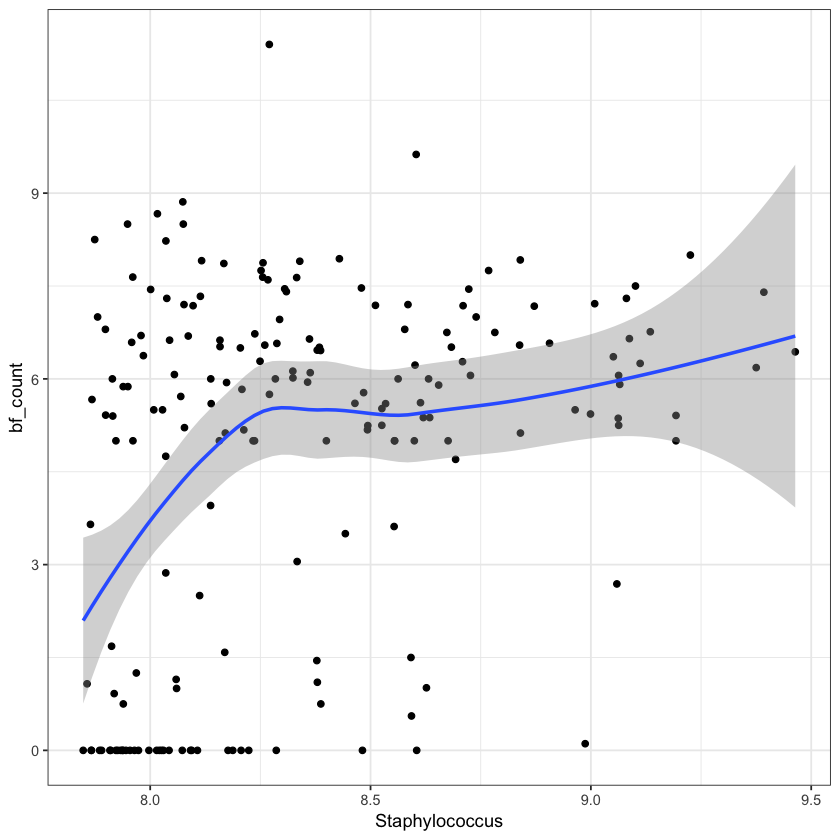

Warning message:
“Removed 10 rows containing non-finite values (stat_density).”

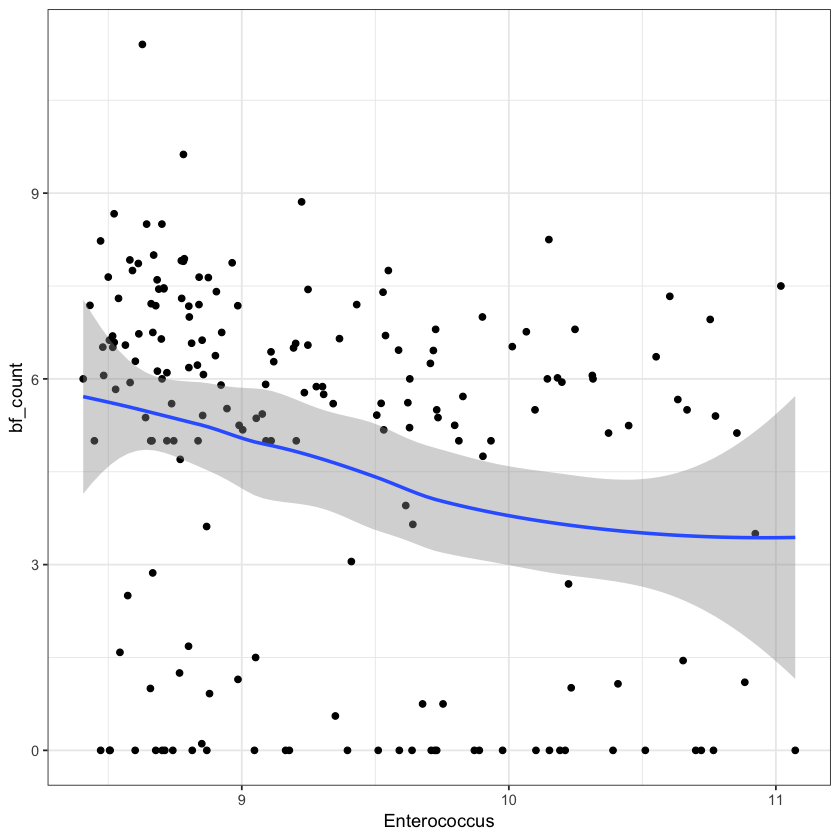

Warning message:
“Removed 10 rows containing non-finite values (stat_density).”

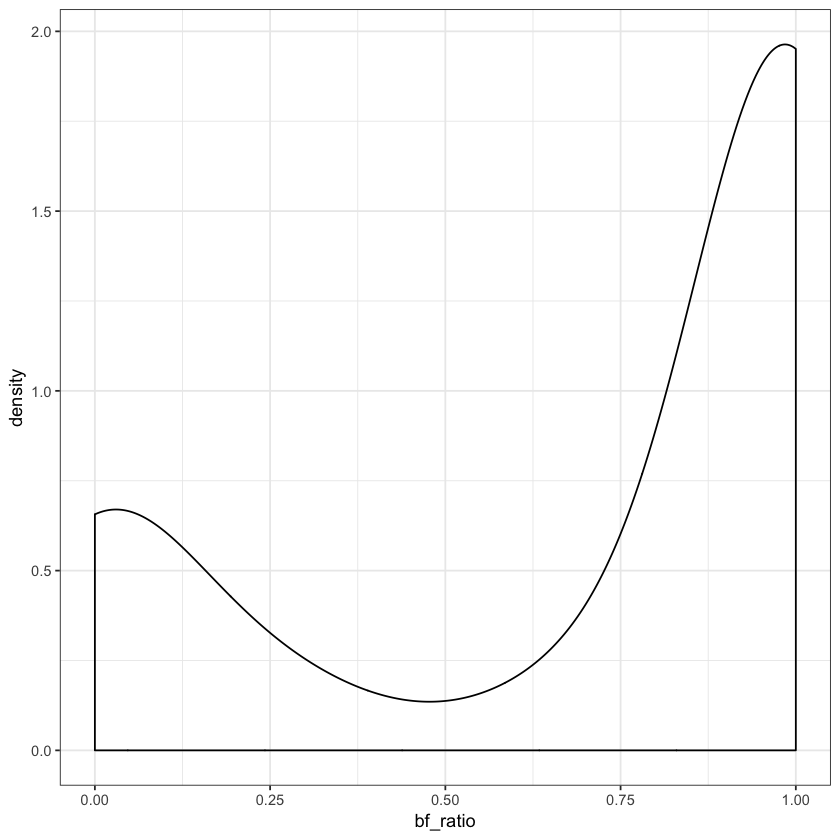

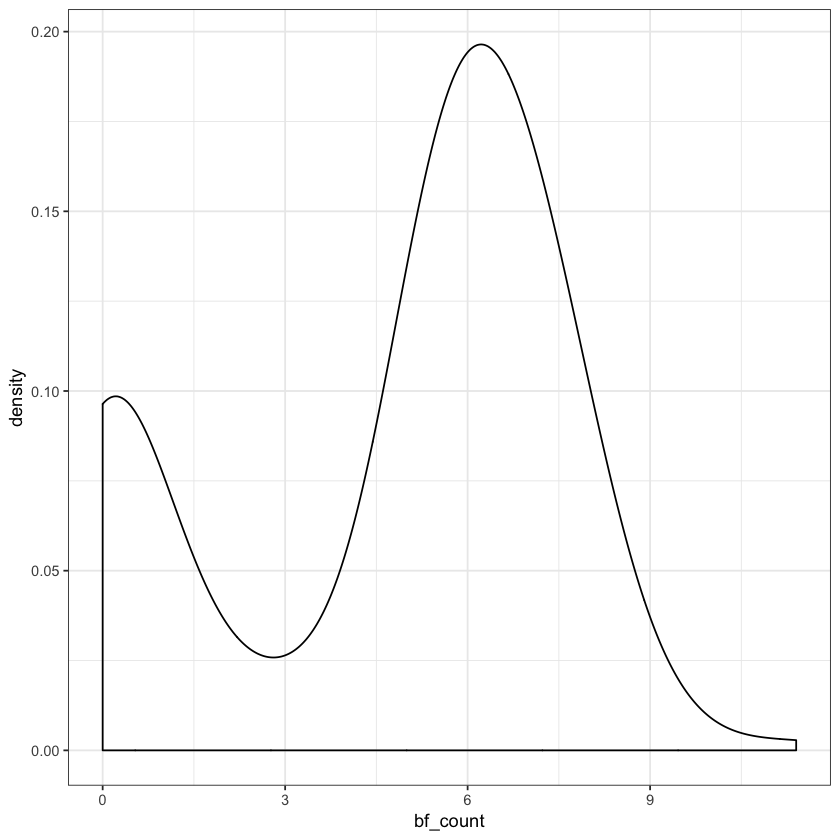

In [144]:
ggplot(data, aes(Staphylococcus, bf_count)) +
    geom_point() +
    geom_smooth()

ggplot(data, aes(Enterococcus, bf_count)) +
    geom_point() +
    geom_smooth()

ggplot(data, aes(bf_ratio)) +
    geom_density()

ggplot(data, aes(bf_count)) +
    geom_density()


Warning message:
“Removed 10 rows containing missing values (geom_text).”

Warning message:
“Removed 10 rows containing missing values (geom_text).”

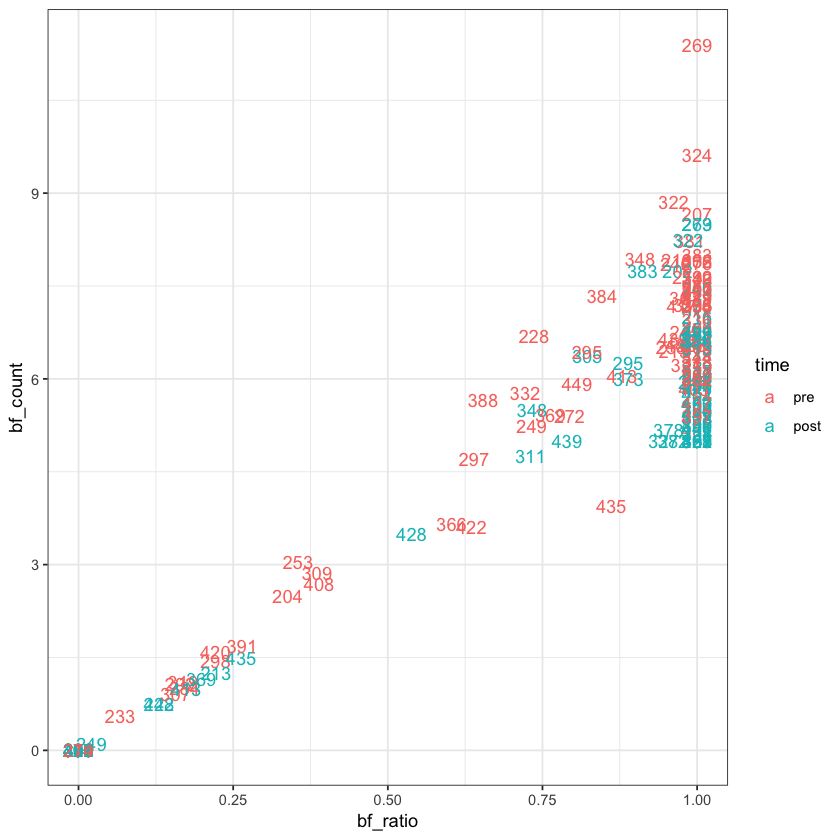

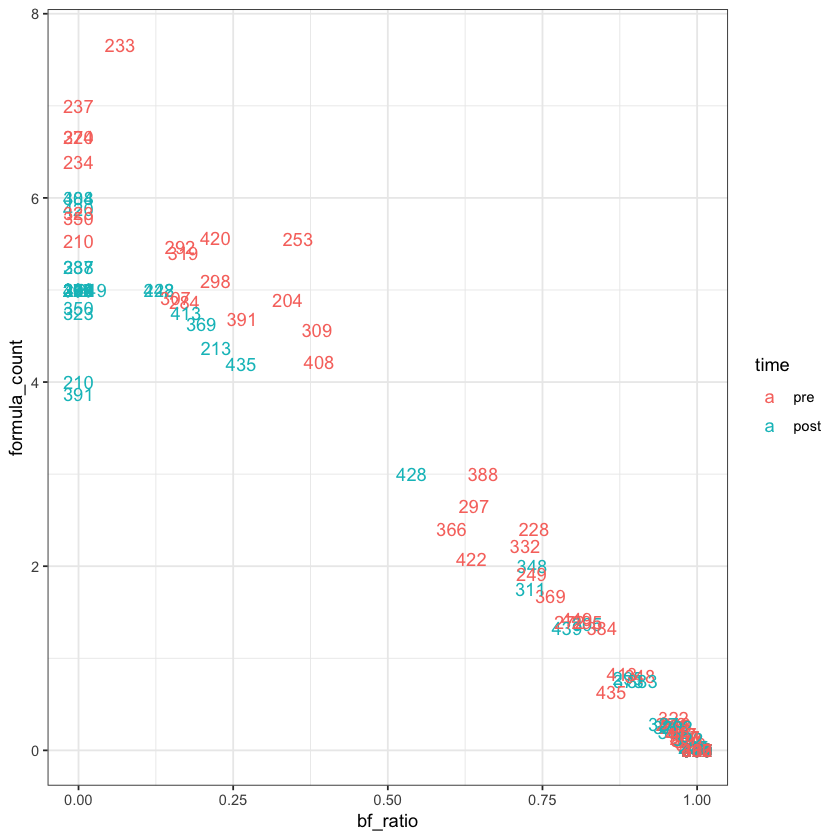

In [145]:
ggplot(data, aes(bf_ratio, bf_count, label = subject_id, color = time)) +
    geom_text()

ggplot(data, aes(bf_ratio, formula_count, label = subject_id, color = time)) +
    geom_text()


## Compare time versus age variables

The information in time (pre/post) is implied in the age variable since for the second samples infants are always older and have had CC (the cc group). Age is a variable we should control for but time (pre/post) and age might mask each other in regression and therefore I think about just using age and then evaluate the interaction with CC. But look at the plot. In the no CC group age is nicely separated. Thus if we compare cc vs no cc, we compare at the same different age at baseline and post treatment. Therefore, I think I need to model the interaction $time \times cc$ and control for age to find out if time and CC explain any additional variance once we know age. But first I will compare age between and within groups to quantify this.

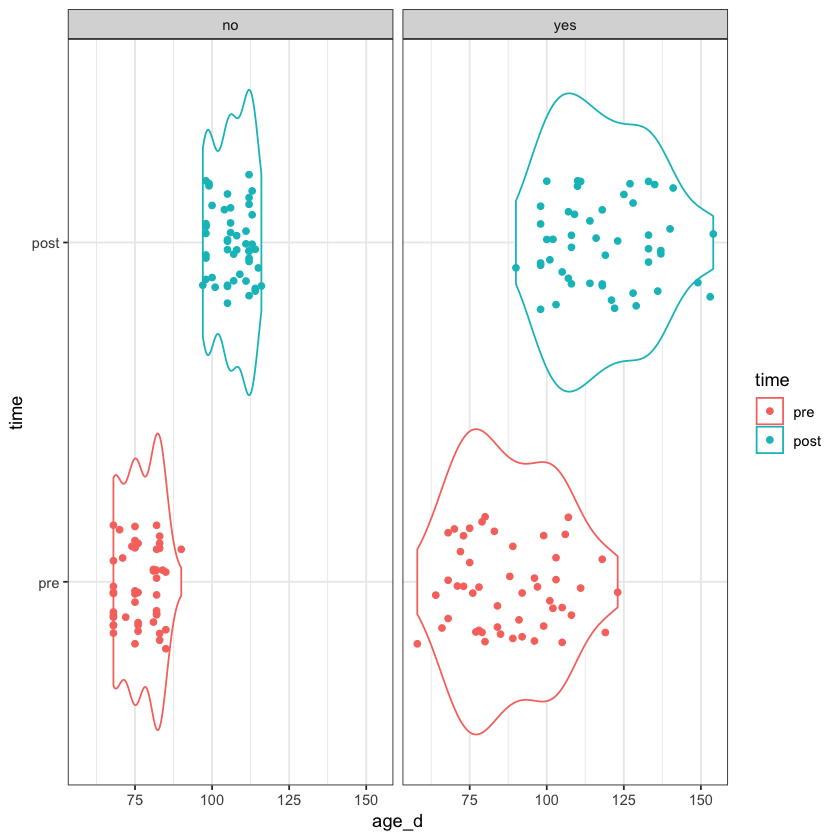

In [23]:
ggplot(data, aes(time, age_d, color = time, label = subject_id)) +
    geom_violin() +
    geom_jitter(width = 0.2) +
    facet_wrap(~cc) +
    coord_flip()

In [86]:
age_all <- brm(bf(age_d ~ time*cc, sigma ~ time*cc), data = data, file = here("models/age_bt_wn"))
age_cc <- brm(bf(age_d ~ cc, sigma ~ cc), data = data, file = here("models/age_bt"))

cc  mean      sd      
1 no   91.58163 16.14747
2 yes 103.12286 22.15521

cc  time mean      sd       
1 no  pre   76.69388  6.259007
2 no  post 106.46939  5.934019
3 yes pre   87.81653 15.957517
4 yes post 118.42918 16.092284

[1] 1

[1] 1

[1] 11.89987

[1] 11.09393

[1] 30.5947

[1] 29.78876

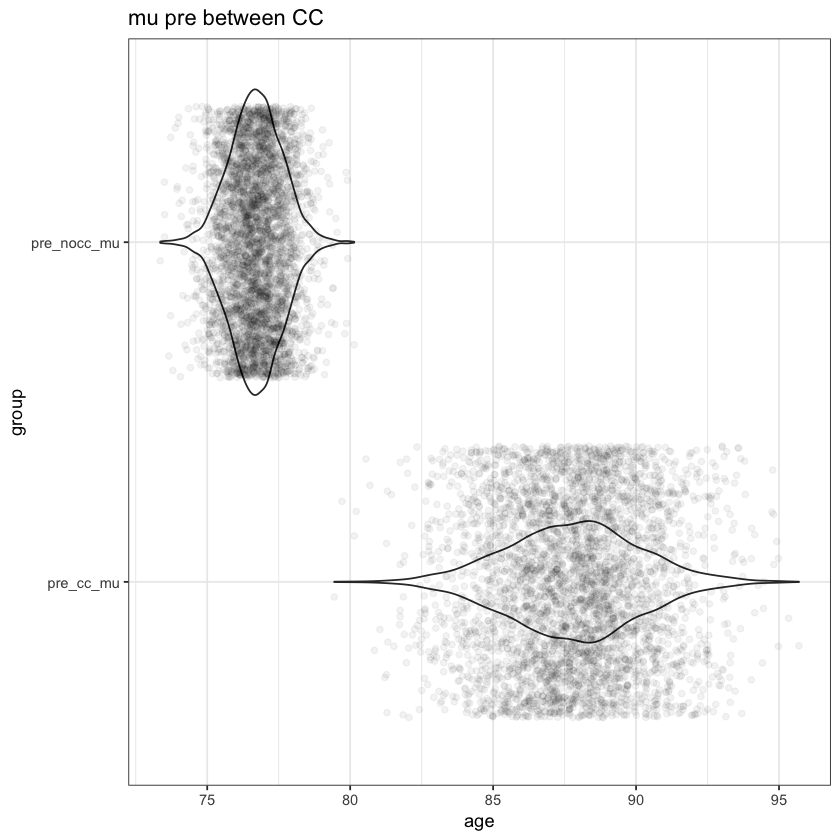

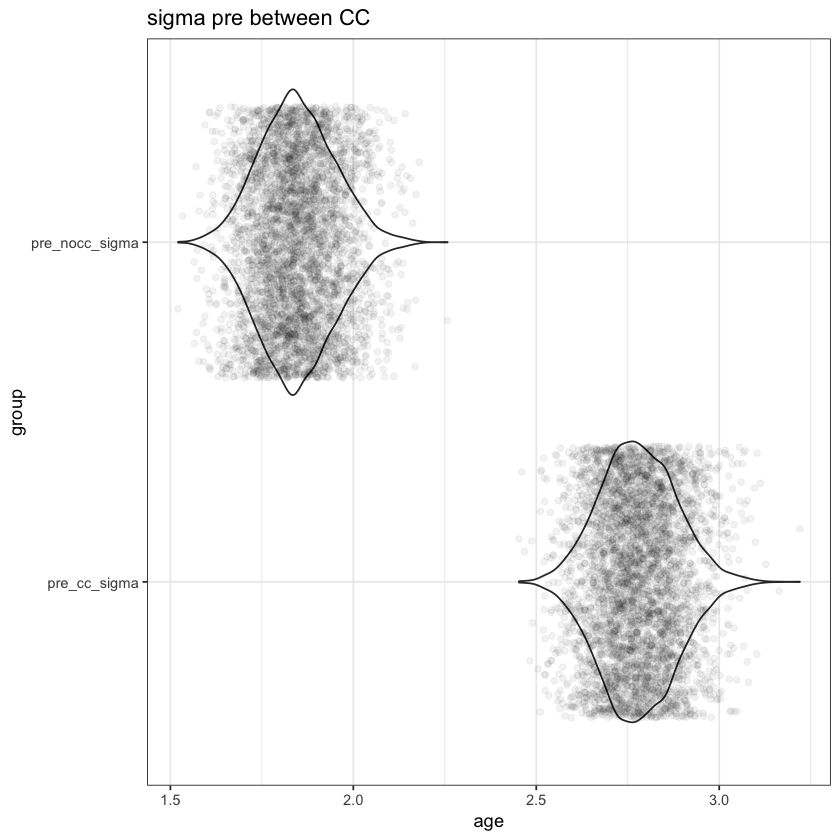

In [87]:
ages_all <-
    age_all %>% 
        as.tibble() %>%
        mutate(
            pre_nocc_mu = b_Intercept,
            pre_cc_mu = b_Intercept + b_ccyes,
            post_nocc_mu = b_Intercept + b_timepost,
            post_cc_mu = b_Intercept + b_timepost + b_ccyes + b_timepost.ccyes, 
            pre_nocc_sigma = b_sigma_Intercept,
            pre_cc_sigma = b_sigma_Intercept + b_sigma_ccyes,
            post_nocc_sigma = b_sigma_Intercept + b_sigma_timepost,
            post_cc_sigma = b_sigma_Intercept + b_sigma_timepost + b_sigma_ccyes + b_sigma_timepost.ccyes) %>%
        select(pre_nocc_mu, pre_cc_mu, post_nocc_mu, post_cc_mu, pre_nocc_sigma, pre_cc_sigma, post_nocc_sigma, post_cc_sigma)
# prob that cc and no cc come from population with different mean age
# sounds kind of stupid since we know their age but the point is to 
# quantify if the difference is so large that it is picked up by the model 
# as such 
data %>% group_by(cc) %>% summarise(mean = mean(age_d), sd = sd(age_d))
data %>% group_by(cc, time) %>% summarise(mean = mean(age_d), sd = sd(age_d))
mean((ages_all$pre_cc_mu - ages_all$pre_nocc_mu) > 0)
# post should be the same but since samples were not given at same time points
# it could in theory differ
mean((ages_all$post_cc_mu - ages_all$post_nocc_mu) > 0)
# average time between groups per time point
mean(ages_all$post_cc_mu - ages_all$post_nocc_mu)
mean(ages_all$pre_cc_mu - ages_all$pre_nocc_mu)
# average time between samples per group
mean(ages_all$post_cc_mu - ages_all$pre_cc_mu)
mean(ages_all$post_nocc_mu - ages_all$pre_nocc_mu)

# plot difference mu
ages_all %>% select(pre_nocc_mu, pre_cc_mu) %>% 
    gather(group, age) %>%
    ggplot(aes(group, age)) +
        geom_violin() +
        geom_jitter(alpha = 0.05) +
        ggtitle("mu pre between CC") +
        coord_flip()

# plot difference sigma
ages_all %>% select(pre_nocc_sigma, pre_cc_sigma) %>% 
    gather(group, age) %>%
    ggplot(aes(group, age)) +
        geom_violin() +
        geom_jitter(alpha = 0.05) +
        ggtitle("sigma pre between CC") +
        coord_flip()

Thus, the ages are "significantly"  different between cc and no cc. Also, there clearly less variation in age in the no cc group. The mean difference is 11 days pre cc and 12 days post cc. The difference between samples is equivalent and is 30 days. However, more than 1 week difference in age might be confounding. I certainly will control for age.

In [45]:
library(mice)
data_imp <-  data %>%
    select(-everything(), subject_id, age_d_s, time, cc, bf_count_s, Enterococcus, Staphylococcus) %>%
    mice(m = 5, print = F)

In [46]:
library(brms)

In [47]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(60)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))

control <- list(adapt_delta = 0.9999, max_treedepth = 15)

ent_time <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + (1+time|subject_id), sigma ~ 1 + time*cc + (1+time|subject_id)), 
        prior = prior_d, file = here("models/ent_time"),
        data = data)

ent_age <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + age_d_s*cc + (1+age_d_s|subject_id), sigma ~ 1 + age_d_s*cc + (1+age_d_s|subject_id)), 
        prior = prior_d, file = here("models/ent_age"),
        data = data)   

ent_time_age <-
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + (1+time + age_d_s|subject_id), sigma ~ 1 + time*cc + age_d_s + (1+time + age_d_s|subject_id)), 
        prior = prior_d, file = here("models/ent_time_age"),
        data = data) 

ent_complete <- 
    brm_multiple(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d, file = here("models/ent_complete"), control = control,
        data = data_imp)

Fitting imputed model 1
Compiling the C++ model
Start sampling
Fitting imputed model 2
Start sampling
Fitting imputed model 3
Start sampling
Fitting imputed model 4
Start sampling
Fitting imputed model 5
Start sampling


In [53]:
broom::tidy(ent_time)[1:12,]
broom::tidy(ent_age)[1:12,]
broom::tidy(ent_time_age)[1:14,]
broom::tidy(ent_complete)[1:14,]

term                           estimate    std.error  lower        
1  b_Intercept                     9.15892339 0.07406438  9.0462807253
2  b_sigma_Intercept              -0.59761637 0.10681810 -0.7664623205
3  b_timepost                      0.25019595 0.12235952  0.0562313956
4  b_ccyes                         0.29061291 0.12955593  0.0856055512
5  b_timepost:ccyes               -0.33560165 0.18824048 -0.6486940815
6  b_sigma_timepost                0.25802896 0.15135003  0.0111315441
7  b_sigma_ccyes                   0.33524941 0.14914928  0.0857643348
8  b_sigma_timepost:ccyes         -0.40492836 0.21280377 -0.7517679692
9  sd_subject_id__Intercept        0.02558290 0.02333856  0.0013129522
10 sd_subject_id__timepost         0.02665790 0.02398407  0.0014339930
11 sd_subject_id__sigma_Intercept  0.01938759 0.01808730  0.0009370664
12 sd_subject_id__sigma_timepost   0.02061735 0.01859139  0.0011864873
   upper      
1   9.28818004
2  -0.41664575
3   0.45556090
4   0.50518481
5  -0.02948045
6   0.50521844
7   0.58344549
8  -0.05167773
9   0.07262054
10  0.07450597
11  0.05551713
12  0.05742530

term                           estimate    std.error  lower        
1  b_Intercept                     9.31669381 0.06798544  9.2097477534
2  b_sigma_Intercept              -0.43608477 0.08223826 -0.5666367792
3  b_age_d_s                       0.10504055 0.07385715 -0.0177336563
4  b_ccyes                         0.08889930 0.10067370 -0.0788508387
5  b_age_d_s:ccyes                -0.08976522 0.09414079 -0.2450118267
6  b_sigma_age_d_s                 0.06796851 0.09113931 -0.0842678276
7  b_sigma_ccyes                   0.10980194 0.11434697 -0.0764149594
8  b_sigma_age_d_s:ccyes          -0.11264579 0.11164645 -0.2968089238
9  sd_subject_id__Intercept        0.02590009 0.02405583  0.0014935808
10 sd_subject_id__age_d_s          0.02062190 0.01824271  0.0013907306
11 sd_subject_id__sigma_Intercept  0.01917112 0.01784885  0.0009933387
12 sd_subject_id__sigma_age_d_s    0.01851575 0.01693171  0.0010864260
   upper      
1   9.43213360
2  -0.29748654
3   0.22472599
4   0.25439423
5   0.06332093
6   0.21604594
7   0.29722939
8   0.07403354
9   0.07278826
10  0.05623186
11  0.05433696
12  0.05288756

term                           estimate    std.error  lower       
1  b_Intercept                     9.19482898 0.10789999  9.019165395
2  b_sigma_Intercept              -0.66471878 0.13920087 -0.884714000
3  b_timepost                      0.19465997 0.16080043 -0.067483882
4  b_ccyes                         0.27652916 0.13834501  0.058923262
5  b_age_d_s                       0.03751917 0.07248738 -0.081985063
6  b_timepost:ccyes               -0.33094189 0.18155538 -0.633732820
7  b_sigma_timepost                0.34334425 0.18982244  0.032555824
8  b_sigma_ccyes                   0.37156322 0.16060653  0.107979043
9  b_sigma_age_d_s                -0.06295202 0.08129694 -0.196262643
10 b_sigma_timepost:ccyes         -0.39313274 0.20813869 -0.741192314
11 sd_subject_id__Intercept        0.02609688 0.02406262  0.001501639
12 sd_subject_id__timepost         0.02659651 0.02487454  0.001601015
13 sd_subject_id__age_d_s          0.02172692 0.01943848  0.001392756
14 sd_subject_id__sigma_Intercept  0.01903590 0.01694035  0.001284620
   upper      
1   9.37423263
2  -0.43486861
3   0.45602884
4   0.51224446
5   0.15671722
6  -0.03996085
7   0.65283494
8   0.63568756
9   0.07240314
10 -0.05257091
11  0.07200774
12  0.07623844
13  0.06029301
14  0.05249813

term                     estimate     std.error  lower        upper       
1  b_Intercept               9.205374498 0.10411225  9.040132146  9.381067820
2  b_sigma_Intercept        -0.701113696 0.14263500 -0.933323487 -0.465514042
3  b_timepost                0.169150707 0.15797404 -0.084706139  0.430779109
4  b_ccyes                   0.240581278 0.12521196  0.038876633  0.448529512
5  b_age_d_s                -0.004593474 0.07238981 -0.122477935  0.115107872
6  b_bf_count_s             -0.174903462 0.05593130 -0.268234572 -0.084957834
7  b_timepost:ccyes         -0.279167852 0.17002165 -0.561553033 -0.004256634
8  b_sigma_timepost          0.354628317 0.19210511  0.039671055  0.671869169
9  b_sigma_ccyes             0.337174172 0.15960067  0.077776286  0.602361235
10 b_sigma_age_d_s          -0.122181827 0.08487303 -0.261334916  0.017139911
11 b_sigma_bf_count_s       -0.161955011 0.06349177 -0.265733710 -0.057198110
12 b_sigma_timepost:ccyes   -0.341015974 0.20903575 -0.685564517  0.003282779
13 sd_subject_id__Intercept  0.030941529 0.02855851  0.001784992  0.088360908
14 sd_subject_id__timepost   0.030612386 0.02762347  0.001769768  0.086010885

In [212]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"))

ent_time2 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time + (1|subject_id), sigma ~ 1 + time + (1|subject_id)), 
        prior = prior_d,
        data = data)

ent_age2 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + age_d_s + (1|subject_id), sigma ~ 1 + age_d_s + (1|subject_id)), 
        prior = prior_d,
        data = data)

Compiling the C++ model
Start sampling
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Compiling the C++ model
Start sampling


In [220]:
broom::tidy(ent_time2)[1:10,]
broom::tidy(ent_age2)[1:10,]

term                           estimate     std.error  lower       
1  b_Intercept                     9.309225286 0.06285768  9.210682132
2  b_sigma_Intercept              -0.408150218 0.07455584 -0.530575910
3  b_timepost                      0.074239553 0.09007750 -0.073519600
4  b_sigma_timepost                0.027065967 0.10535335 -0.148466687
5  sd_subject_id__Intercept        0.027607146 0.02398027  0.001978423
6  sd_subject_id__sigma_Intercept  0.024010266 0.02111415  0.001335747
7  alpha                          10.681251669 2.12099446  7.414368215
8  r_subject_id[202,Intercept]    -0.003893706 0.03413193 -0.060866375
9  r_subject_id[204,Intercept]    -0.004493113 0.03419113 -0.060793227
10 r_subject_id[207,Intercept]    -0.015894944 0.03834529 -0.092837710
   upper      
1   9.41665300
2  -0.28507370
3   0.22332583
4   0.20036243
5   0.07324782
6   0.06570922
7  14.33859403
8   0.04251505
9   0.04430412
10  0.02412863

term                           estimate     std.error  lower       
1  b_Intercept                     9.346680336 0.04618394  9.274152358
2  b_sigma_Intercept              -0.401045148 0.05372841 -0.486330588
3  b_age_d_s                       0.053719815 0.04334968 -0.015950686
4  b_sigma_age_d_s                 0.002069695 0.05002279 -0.079653756
5  sd_subject_id__Intercept        0.026651656 0.02384791  0.001485469
6  sd_subject_id__sigma_Intercept  0.024162748 0.02028777  0.001798893
7  alpha                          10.827501660 2.12644360  7.598227075
8  r_subject_id[202,Intercept]    -0.003792804 0.03332476 -0.062061615
9  r_subject_id[204,Intercept]    -0.002408658 0.03398560 -0.060635695
10 r_subject_id[207,Intercept]    -0.012709869 0.03654066 -0.080123865
   upper      
1   9.42656579
2  -0.31061490
3   0.12612970
4   0.08373672
5   0.07334783
6   0.06441448
7  14.60165448
8   0.04222172
9   0.04789280
10  0.02926820

In [224]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(30)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))

#ent_time3 <- 
 #   brm(
  #      family = skew_normal(), 
   #     bf(Enterococcus ~ 1 + time*cc + (1+time|subject_id), sigma ~ 1 + time*cc + (1+time|subject_id)), 
    #    prior = prior_d,
     #   data = data)

ent_age3 <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + (1 + time + age_d_s|subject_id), sigma ~ 1 + time*cc + age_d_s + (1 + time + age_d_s|subject_id)), 
        prior = prior_d,
        data = data) 

Compiling the C++ model
Start sampling


In [225]:
broom::tidy(ent_time3)[1:10,]
broom::tidy(ent_age3)[1:10,]

term                     estimate    std.error  lower        upper      
1  b_Intercept               9.15943370 0.07688515  9.042518714  9.29151588
2  b_sigma_Intercept        -0.59675021 0.10837107 -0.772676456 -0.41276152
3  b_timepost                0.24862271 0.12414268  0.053779367  0.45534622
4  b_ccyes                   0.29252410 0.13005721  0.090380195  0.50486823
5  b_timepost:ccyes         -0.33615661 0.18463977 -0.642483478 -0.03831957
6  b_sigma_timepost          0.25624680 0.15174871  0.004912083  0.50990585
7  b_sigma_ccyes             0.33809416 0.15149696  0.096608256  0.58626272
8  b_sigma_timepost:ccyes   -0.40479102 0.21383489 -0.760570609 -0.05223114
9  sd_subject_id__Intercept  0.02486777 0.02286049  0.001451940  0.06918548
10 sd_subject_id__timepost   0.02633930 0.02411243  0.001579677  0.07444864

term                   estimate    std.error  lower       upper      
1  b_Intercept             9.19457116 0.10978325  9.02328571  9.38565450
2  b_sigma_Intercept      -0.66773386 0.14317438 -0.89697362 -0.42569289
3  b_timepost              0.19509684 0.16437864 -0.07307193  0.46541074
4  b_ccyes                 0.27684015 0.13667739  0.05662700  0.50321055
5  b_age_d_s               0.03775606 0.07432771 -0.08371038  0.16231231
6  b_timepost:ccyes       -0.32996329 0.17942708 -0.62697561 -0.04634257
7  b_sigma_timepost        0.34602694 0.19716527  0.02335860  0.67174841
8  b_sigma_ccyes           0.37422178 0.16181763  0.10486290  0.64257486
9  b_sigma_age_d_s        -0.06456826 0.08422579 -0.20236755  0.07322861
10 b_sigma_timepost:ccyes -0.39494704 0.20792658 -0.73236882 -0.04966145

In [234]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(30)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 10)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))



ent_complete <- 
    brm(
        family = skew_normal(), 
        bf(Enterococcus ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d,
        data = data) 
broom::tidy(ent_age3)[1:10,]
broom::tidy(ent_complete)[1:10,]

Warning message:
“Rows containing NAs were excluded from the model.”Compiling the C++ model
Start sampling


In [24]:
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(30)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(50)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 3)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))



bif_complete <- 
    brm(
        family = skew_normal(), 
        bf(Bifidobacterium ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id), sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)), 
        prior = prior_d,
        control = list(adapt_delta = 0.9999, max_treedepth = 15),
        data = data)

Warning message:
“Rows containing NAs were excluded from the model.”Compiling the C++ model
Start sampling


In [27]:
source(here("R/bayesian_helper.R"))
broom::tidy(bif_complete)[1:14,]
bif_complete %>% 
    as.tibble() %>%
    gather(term, estimate) %>%
    group_by(term) %>%
    do(data.frame(
        mean = round(mean(.$estimate), 2),
        lower = round(hpdi(.$estimate)[1], 2),
        upper = round(hpdi(.$estimate)[2], 2)
    ))

term                     estimate     std.error  lower        upper      
1  b_Intercept              10.855158321 0.09399516 10.702220316 11.01100367
2  b_sigma_Intercept        -0.507354443 0.15728862 -0.768704368 -0.26159306
3  b_timepost                0.111435369 0.11814223 -0.083059567  0.30196817
4  b_ccyes                  -0.010567899 0.10396752 -0.184086079  0.16111714
5  b_age_d_s                -0.093815017 0.04811860 -0.173062545 -0.01371855
6  b_bf_count_s              0.038416111 0.03292339 -0.014330546  0.09301892
7  b_timepost:ccyes          0.291537583 0.12914424  0.086971068  0.50456172
8  b_sigma_timepost         -0.307273980 0.19931336 -0.636119386  0.02339633
9  b_sigma_ccyes             0.001181108 0.16530384 -0.264011232  0.27970398
10 b_sigma_age_d_s           0.183596811 0.08858447  0.042010249  0.32896459
11 b_sigma_bf_count_s       -0.041771780 0.06522310 -0.148683643  0.06501351
12 b_sigma_timepost:ccyes   -0.627250159 0.23783014 -1.019609819 -0.25000508
13 sd_subject_id__Intercept  0.037993981 0.03373705  0.002518445  0.10546528
14 sd_subject_id__timepost   0.025730689 0.02328740  0.001402598  0.07071895

term                                              mean     lower   
1   alpha                                                -9.07   -13.38
2   b_Intercept                                          10.86    10.67
3   b_age_d_s                                            -0.09    -0.19
4   b_bf_count_s                                          0.04    -0.03
5   b_ccyes                                              -0.01    -0.22
6   b_sigma_Intercept                                    -0.51    -0.80
7   b_sigma_age_d_s                                       0.18     0.01
8   b_sigma_bf_count_s                                   -0.04    -0.17
9   b_sigma_ccyes                                         0.00    -0.32
10  b_sigma_timepost                                     -0.31    -0.70
11  b_sigma_timepost.ccyes                               -0.63    -1.07
12  b_timepost                                            0.11    -0.13
13  b_timepost.ccyes                                      0.29     0.02
14  cor_subject_id__Intercept__age_d_s                   -0.03    -0.70
15  cor_subject_id__Intercept__bf_count_s                 0.03    -0.69
16  cor_subject_id__Intercept__timepost                   0.01    -0.66
17  cor_subject_id__age_d_s__bf_count_s                  -0.01    -0.71
18  cor_subject_id__sigma_Intercept__sigma_age_d_s       -0.02    -0.71
19  cor_subject_id__sigma_Intercept__sigma_bf_count_s     0.00    -0.66
20  cor_subject_id__sigma_Intercept__sigma_timepost       0.01    -0.72
21  cor_subject_id__sigma_age_d_s__sigma_bf_count_s       0.00    -0.75
22  cor_subject_id__sigma_timepost__sigma_age_d_s         0.00    -0.70
23  cor_subject_id__sigma_timepost__sigma_bf_count_s      0.00    -0.70
24  cor_subject_id__timepost__age_d_s                    -0.04    -0.71
25  cor_subject_id__timepost__bf_count_s                  0.02    -0.66
26  lp__                                              -1192.11 -1232.19
27  r_subject_id.202.Intercept.                           0.01    -0.08
28  r_subject_id.202.age_d_s.                             0.00    -0.06
29  r_subject_id.202.bf_count_s.                          0.00    -0.08
30  r_subject_id.202.timepost.                            0.00    -0.08
⋮   ⋮                                                 ⋮        ⋮       
749 r_subject_id__sigma.437.bf_count_s.                0.00    -0.06   
750 r_subject_id__sigma.437.timepost.                  0.00    -0.06   
751 r_subject_id__sigma.439.Intercept.                -0.01    -0.15   
752 r_subject_id__sigma.439.age_d_s.                   0.00    -0.07   
753 r_subject_id__sigma.439.bf_count_s.                0.00    -0.06   
754 r_subject_id__sigma.439.timepost.                  0.00    -0.07   
755 r_subject_id__sigma.442.Intercept.                -0.01    -0.15   
756 r_subject_id__sigma.442.age_d_s.                   0.00    -0.06   
757 r_subject_id__sigma.442.bf_count_s.                0.00    -0.06   
758 r_subject_id__sigma.442.timepost.                  0.00    -0.06   
759 r_subject_id__sigma.446.Intercept.                 0.01    -0.09   
760 r_subject_id__sigma.446.age_d_s.                   0.00    -0.06   
761 r_subject_id__sigma.446.bf_count_s.                0.00    -0.06   
762 r_subject_id__sigma.446.timepost.                  0.00    -0.06   
763 r_subject_id__sigma.449.Intercept.                 0.01    -0.13   
764 r_subject_id__sigma.449.age_d_s.                   0.00    -0.07   
765 r_subject_id__sigma.449.bf_count_s.                0.00    -0.06   
766 r_subject_id__sigma.449.timepost.                  0.00    -0.06   
767 r_subject_id__sigma.452.Intercept.                -0.01    -0.15   
768 r_subject_id__sigma.452.age_d_s.                   0.00    -0.07   
769 r_subject_id__sigma.452.bf_count_s.                0.00    -0.07   
770 r_subject_id__sigma.452.timepost.                  0.00    -0.06   
771 sd_subject_id__Intercept                           0.04     0.00   
772 sd_subject_id__age_d_s                  

In [258]:
exp(-1.0396) # sigma cc no pre
exp(-1.0396 + 0.25301870) # sigma cc yes pre
exp(-1.0396 - 0.32468744) # sigma cc no post
exp(-1.0396 - 0.32468744 + 0.25301870 -0.68752035) # sigma cc yes post

[1] 0.3535961

[1] 0.455399

[1] 0.2555627

[1] 0.1654992

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10 rows containing missing values (geom_point).”


	Pearson's product-moment correlation

data:  data$bf_count and data$age_d
t = -3.71, df = 184, p-value = 0.0002744
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3927848 -0.1246673
sample estimates:
       cor 
-0.2638146 


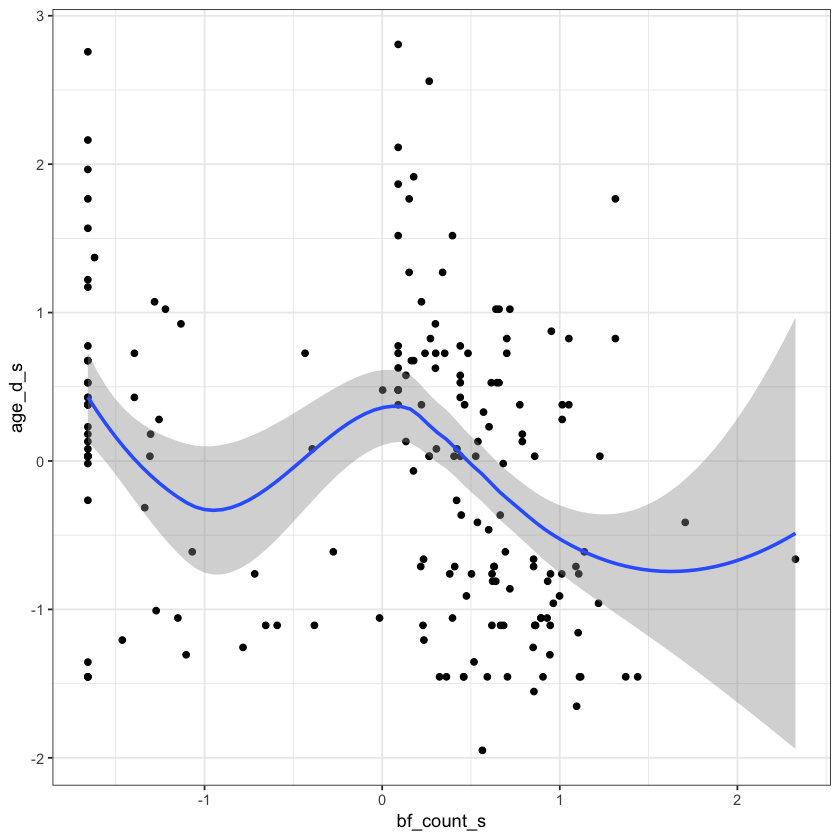

In [52]:
ggplot(data, aes(bf_count_s, age_d_s)) +
    geom_point() +
    geom_smooth()

cor.test(data$bf_count, data$age_d)

In [88]:
dim(data)

[1] 196 153

In [143]:
# select only genus that Gerben preselected, then save data
test <- read_csv(here("data/csv_gerben/data1.csv"))
selector <- colnames(test)

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  X1_1 = col_character(),
  subject = col_integer(),
  age_weeks = col_integer(),
  feeding_type = col_character(),
  time = col_integer(),
  childcarecenter = col_character()
)
See spec(...) for full column specifications.


In [144]:
selector <- selector[-c(1:2, 114:119)]

In [154]:
colnames(data)
data_transfer <- 
    data %>% select(
        subject_id, 
        time, 
        cc, 
        age_d, 
        age_d_s, 
        bf_count, 
        bf_count_s, 
        selector)
#save(data_transfer, file = here("data/data_transfer.RData"))

[1] "subject_id"                          
  [2] "time"                                
  [3] "cc"                                  
  [4] "age_pre_d"                           
  [5] "age_post_d"                          
  [6] "age_startcc_w"                       
  [7] "weeks_cc"                            
  [8] "sample"                              
  [9] "bf_count_pre"                        
 [10] "bf_count_post"                       
 [11] "bf_count_cc"                         
 [12] "formula_count_pre"                   
 [13] "formula_count_post"                  
 [14] "formula_count_cc"                    
 [15] "bf_ratio_pre"                        
 [16] "bf_ratio_cc"                         
 [17] "bf_ratio"                            
 [18] "bf_count"                            
 [19] "formula_count"                       
 [20] "age_d"                               
 [21] "Actinomycetaceae"                    
 [22] "Aerococcus"                          
 [23] "Aeromonas"                           
 [24] "Akkermansia"                         
 [25] "Alcaligenes_faecalis_et_rel"         
 [26] "Allistipes_et_rel"                   
 [27] "Anaerobiospirillum"                  
 [28] "Anaerofustis"                        
 [29] "Anaerostipes_caccae_et_rel"          
 [30] "Anaerotruncus_colihominis_et_rel"    
 [31] "Anaerovorax_odorimutans_et_rel"      
 [32] "Aneurinibacillus"                    
 [33] "Aquabacterium"                       
 [34] "Asteroleplasma_et_rel"               
 [35] "Atopobium"                           
 [36] "Bacillus"                            
 [37] "Bacteroides_fragilis_et_rel"         
 [38] "Bacteroides_intestinalis_et_rel"     
 [39] "Bacteroides_ovatus_et_rel"           
 [40] "Bacteroides_plebeius_et_rel"         
 [41] "Bacteroides_splachnicus_et_rel"      
 [42] "Bacteroides_stercoris_et_rel"        
 [43] "Bacteroides_uniformis_et_rel"        
 [44] "Bacteroides_vulgatus_et_rel"         
 [45] "Bifidobacterium"                     
 [46] "Bilophila_et_rel"                    
 [47] "Brachyspira"                         
 [48] "Bryantella_formatexigens_et_rel"     
 [49] "Bulleidia_moorei_et_rel"             
 [50] "Burkholderia"                        
 [51] "Butyrivibrio_crossotus_et_rel"       
 [52] "Campylobacter"                       
 [53] "Catenibacterium_mitsuokai_et_rel"    
 [54] "Clostridium_sensu_stricto"           
 [55] "Clostridium_cellulosi_et_rel"        
 [56] "Clostridium_colinum_et_rel"          
 [57] "Clostridium_difficile_et_rel"        
 [58] "Clostridium_felsineum_et_rel"        
 [59] "Clostridium_leptum_et_rel"           
 [60] "Clostridium_nexile_et_rel"           
 [61] "Clostridium_orbiscindens_et_rel"     
 [62] "Clostridium_ramosum_et_rel"          
 [63] "Clostridium_sphenoides_et_rel"       
 [64] "Clostridium_stercorarium_et_rel"     
 [65] "Clostridium_symbiosum_et_rel"        
 [66] "Clostridium_thermocellum_et_rel"     
 [67] "Collinsella"                         
 [68] "Coprobacillus_catenaformis_et_rel"   
 [69] "Coprococcus_eutactus_et_rel"         
 [70] "Corynebacterium"                     
 [71] "Desulfovibrio_et_rel"                
 [72] "Dialister"                           
 [73] "Dorea_formicigenerans_et_rel"        
 [74] "Eggerthella_lenta_et_rel"            
 [75] "Enterobacter_aerogenes_et_rel"       
 [76] "Enterococcus"                        
 [77] "Escherichia_coli_et_rel"             
 [78] "Eubacterium_biforme_et_rel"          
 [79] "Eubacterium_cylindroides_et_rel"     
 [80] "Eubacterium_hallii_et_rel"           
 [81] "Eubacterium_limosum_et_rel"          
 [82] "Eubacterium_rectale_et_rel"          
 [83] "Eubacterium_siraeum_et_rel"          
 [84] "Eubacterium_ventriosum_et_rel"       
 [85] "Faecalibacterium_prausnitzii_et_rel" 
 [86] "Fusobacteria"                        
 [87] "Gemella"                             
 [88] "Granulicatella"                      
 [89] "Haemophilus"                       